In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils import data

from tqdm import tqdm
import seaborn as sns

In [41]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [42]:
df

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,BS,ROP,DTS,DCAL,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,1518.2800,433906.7500,6460000.5,-1493.241821,15.506232,1.461974,0.878615,2.345301,103.451515,0.439925,5.820852,147.043427,17.5,146.526276,326.451263,-1.993768,0.109706,88.968864,65000.0,3.0
1,1518.4320,433906.7500,6460000.5,-1493.393799,18.524611,1.461974,0.874237,2.345301,94.124893,0.504055,5.820852,145.426468,17.5,147.605148,322.926361,1.024611,-0.006418,92.287186,65000.0,3.0
2,1518.5840,433906.7500,6460000.5,-1493.545776,18.855669,1.461974,0.869858,2.345301,93.586487,0.512960,5.820852,145.295105,17.5,140.783127,325.283142,1.355668,0.022769,95.605499,65000.0,3.0
3,1518.7360,433906.7500,6460000.5,-1493.697754,19.163353,1.461974,0.865479,2.345301,91.113373,0.500070,5.820852,143.657593,17.5,125.159531,334.233185,1.663353,0.024972,98.923820,65000.0,3.0
4,1518.8880,433906.7500,6460000.5,-1493.849609,18.489744,0.849849,0.863804,2.345301,100.228333,0.277670,5.820852,142.838440,17.5,107.576691,330.952362,0.989743,0.024527,102.242142,65000.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121419,2973.2988,536096.0625,6793022.0,-2943.444580,8.276272,2.820439,3.158570,2.373673,90.720284,0.156916,3.806974,75.260658,8.5,15.195305,136.911575,0.240471,0.502458,24.306124,65000.0,2.0
121420,2973.4508,536096.0625,6793022.0,-2943.595947,8.267273,3.020778,3.332977,2.373673,87.062027,0.156916,3.806974,74.868301,8.5,15.770223,137.583923,0.240471,0.374753,22.201078,65000.0,2.0
121421,2973.6028,536096.0625,6793022.0,-2943.747559,8.250099,2.795711,3.044179,2.373673,86.115921,0.156916,3.806974,74.848122,8.5,16.418465,138.310898,0.240471,0.211487,20.096741,65000.0,2.0
121422,2973.7548,536096.0625,6793022.0,-2943.899170,8.250099,2.658694,2.847681,2.373673,89.497131,0.156916,3.806974,74.964027,8.5,17.037945,137.592819,0.240471,0.147950,17.992323,65000.0,2.0


In [43]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [44]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [45]:
df.loc[[13]]

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,BS,ROP,DTS,DCAL,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
13,1520.256,433906.78125,6460000.5,-1495.217651,12.564576,1.008002,0.962722,2.345301,129.729172,0.431906,5.820852,147.448441,17.5,119.822624,332.247375,-4.935423,0.176844,90.155342,2,3.0


In [46]:
# import random

# ind_list = [i for i in range(df.shape[0])]

# msk = random.sample(ind_list, int(len(ind_list)*0.2))
# df_train = df.loc[msk]
# test_msk = list(set(ind_list) - set(msk))
# df_test = df.loc[test_msk]
# 

In [47]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [48]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [49]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [50]:
dataset = CustomDataset(dataframe=df, feature_names=feature_names, target_name=target_name)

train_, test = data.random_split(dataset, [0.8, 0.2])
train, val = data.random_split(train_, [0.7, 0.3])

In [51]:
train_data = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_data = DataLoader(dataset=val, batch_size=64, shuffle=True)
test_data = DataLoader(dataset=test, batch_size=64, shuffle=False)

In [52]:
# feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
#                  'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

# target_name = 'FORCE_2020_LITHOFACIES_LITHOLOGY'

# train_dataset = CustomDataset(dataframe=df_train, feature_names=feature_names, target_name=target_name)
# train_data = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, )

# test_dataset = CustomDataset(dataframe=df_test, feature_names=feature_names, target_name=target_name)
# test_data = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, )

In [53]:
len(feature_names)

18

In [54]:
model = nn.Sequential(
    nn.Conv1d(1, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv1d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.Conv1d(128, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv1d(64, 64, 3, padding=1),
    nn.ReLU(),
    # nn.Conv1d(64, 128, 3, padding=1),
    # nn.ReLU(),
    # nn.Conv1d(128, 128, 3, padding=1),
    # nn.ReLU(),
    # nn.Conv1d(128, 128, 1, padding=1),
    nn.Flatten(),
    nn.Linear(1152, 32),
    nn.ReLU(),
    nn.Linear(32, len(target_name))
)

In [55]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

In [56]:
epochs = 5
model.train()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): ReLU()
  (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1152, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=11, bias=True)
)

In [57]:
for e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=False)
    for x_train, y_train in train_tqdm:
        print(x_train.shape)
        print(y_train.shape)
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')

  0%|          | 0/1063 [00:00<?, ?it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=2.325 :   0%|          | 2/1063 [00:01<08:35,  2.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=2.075 :   1%|          | 6/1063 [00:01<02:26,  7.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.946 :   1%|          | 11/1063 [00:01<01:22, 12.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.789 :   2%|▏         | 17/1063 [00:01<00:57, 18.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.769 :   2%|▏         | 20/1063 [00:02<00:51, 20.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.694 :   2%|▏         | 26/1063 [00:02<00:51, 20.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.677 :   3%|▎         | 29/1063 [00:02<00:54, 18.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.616 :   3%|▎         | 35/1063 [00:02<00:54, 19.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.594 :   3%|▎         | 37/1063 [00:02<00:56, 18.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.548 :   4%|▍         | 41/1063 [00:03<01:03, 16.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.518 :   4%|▍         | 47/1063 [00:03<00:50, 20.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.482 :   5%|▍         | 50/1063 [00:03<00:48, 20.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.453 :   5%|▌         | 56/1063 [00:03<00:43, 23.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.444 :   5%|▌         | 56/1063 [00:03<00:43, 23.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.401 :   6%|▌         | 61/1063 [00:04<01:11, 13.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.376 :   6%|▌         | 64/1063 [00:04<01:01, 16.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.335 :   7%|▋         | 70/1063 [00:04<00:51, 19.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.313 :   7%|▋         | 76/1063 [00:04<00:45, 21.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.280 :   7%|▋         | 79/1063 [00:05<00:45, 21.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.262 :   8%|▊         | 82/1063 [00:05<00:43, 22.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.244 :   8%|▊         | 88/1063 [00:05<00:51, 18.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.228 :   9%|▊         | 91/1063 [00:05<00:50, 19.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.210 :   9%|▉         | 97/1063 [00:05<00:44, 21.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.188 :   9%|▉         | 100/1063 [00:06<00:44, 21.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.158 :  10%|▉         | 106/1063 [00:06<00:40, 23.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.148 :  10%|█         | 109/1063 [00:06<00:38, 24.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.132 :  11%|█         | 112/1063 [00:07<01:13, 12.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.129 :  11%|█         | 114/1063 [00:07<01:09, 13.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.119 :  11%|█         | 116/1063 [00:07<01:27, 10.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.109 :  11%|█▏        | 120/1063 [00:07<01:14, 12.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.102 :  11%|█▏        | 122/1063 [00:07<01:15, 12.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.086 :  12%|█▏        | 124/1063 [00:08<01:10, 13.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.069 :  12%|█▏        | 129/1063 [00:08<00:58, 15.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.051 :  13%|█▎        | 134/1063 [00:08<00:51, 17.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.045 :  13%|█▎        | 136/1063 [00:08<00:51, 17.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.032 :  13%|█▎        | 142/1063 [00:08<00:44, 20.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.015 :  14%|█▍        | 148/1063 [00:09<00:41, 22.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.009 :  14%|█▍        | 151/1063 [00:09<00:41, 22.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=1.004 :  14%|█▍        | 154/1063 [00:09<00:38, 23.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.996 :  15%|█▍        | 157/1063 [00:09<01:11, 12.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.987 :  15%|█▌        | 163/1063 [00:10<00:57, 15.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.980 :  16%|█▌        | 165/1063 [00:10<00:59, 15.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.974 :  16%|█▌        | 167/1063 [00:10<00:56, 15.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.963 :  16%|█▌        | 172/1063 [00:10<00:49, 17.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.959 :  17%|█▋        | 176/1063 [00:10<00:43, 20.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.949 :  17%|█▋        | 182/1063 [00:11<00:41, 21.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.938 :  17%|█▋        | 186/1063 [00:11<00:39, 22.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.931 :  18%|█▊        | 192/1063 [00:11<00:37, 23.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.922 :  19%|█▊        | 198/1063 [00:11<00:38, 22.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.917 :  19%|█▉        | 201/1063 [00:11<00:40, 21.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.907 :  19%|█▉        | 204/1063 [00:12<00:39, 21.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.907 :  19%|█▉        | 207/1063 [00:12<00:37, 22.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.900 :  19%|█▉        | 207/1063 [00:12<00:37, 22.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.894 :  20%|█▉        | 212/1063 [00:12<01:09, 12.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.893 :  20%|██        | 215/1063 [00:12<00:58, 14.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.887 :  20%|██        | 217/1063 [00:13<01:07, 12.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.879 :  21%|██        | 222/1063 [00:13<00:53, 15.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.874 :  21%|██▏       | 228/1063 [00:13<00:44, 18.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.867 :  22%|██▏       | 231/1063 [00:13<00:42, 19.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.861 :  22%|██▏       | 237/1063 [00:14<00:39, 20.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.857 :  23%|██▎       | 240/1063 [00:14<00:39, 20.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.854 :  23%|██▎       | 243/1063 [00:14<00:38, 21.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.849 :  23%|██▎       | 249/1063 [00:14<00:39, 20.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.844 :  24%|██▎       | 252/1063 [00:14<00:38, 21.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.843 :  24%|██▍       | 255/1063 [00:14<00:38, 20.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.838 :  24%|██▍       | 258/1063 [00:15<01:14, 10.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.834 :  24%|██▍       | 260/1063 [00:15<01:12, 11.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.831 :  25%|██▍       | 263/1063 [00:15<01:06, 12.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.827 :  25%|██▌       | 267/1063 [00:16<01:00, 13.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.822 :  25%|██▌       | 270/1063 [00:16<00:52, 15.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.816 :  26%|██▌       | 275/1063 [00:16<00:44, 17.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.812 :  26%|██▌       | 279/1063 [00:16<00:38, 20.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.808 :  27%|██▋       | 285/1063 [00:16<00:37, 20.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.806 :  27%|██▋       | 288/1063 [00:17<00:36, 21.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.804 :  27%|██▋       | 291/1063 [00:17<00:43, 17.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.802 :  28%|██▊       | 293/1063 [00:17<00:52, 14.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.799 :  28%|██▊       | 295/1063 [00:17<01:04, 11.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.797 :  28%|██▊       | 297/1063 [00:17<01:12, 10.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.795 :  28%|██▊       | 297/1063 [00:18<01:12, 10.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.795 :  28%|██▊       | 300/1063 [00:18<01:59,  6.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.793 :  28%|██▊       | 302/1063 [00:19<01:38,  7.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.791 :  29%|██▊       | 304/1063 [00:19<01:28,  8.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.791 :  29%|██▉       | 306/1063 [00:19<01:23,  9.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.788 :  29%|██▉       | 308/1063 [00:19<01:31,  8.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.785 :  29%|██▉       | 312/1063 [00:19<01:08, 11.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.781 :  30%|██▉       | 316/1063 [00:20<01:02, 12.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.780 :  30%|██▉       | 318/1063 [00:20<01:06, 11.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.778 :  30%|███       | 320/1063 [00:20<01:06, 11.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.775 :  30%|███       | 324/1063 [00:20<00:55, 13.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.773 :  31%|███       | 326/1063 [00:21<00:55, 13.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.772 :  31%|███       | 328/1063 [00:21<01:08, 10.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.772 :  31%|███       | 328/1063 [00:21<01:08, 10.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.769 :  31%|███       | 331/1063 [00:22<02:12,  5.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.767 :  31%|███▏      | 333/1063 [00:22<01:43,  7.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.766 :  31%|███▏      | 333/1063 [00:22<01:43,  7.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.765 :  32%|███▏      | 336/1063 [00:22<02:11,  5.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.763 :  32%|███▏      | 338/1063 [00:23<01:47,  6.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.760 :  32%|███▏      | 341/1063 [00:23<01:25,  8.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.758 :  32%|███▏      | 343/1063 [00:23<01:12,  9.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.756 :  33%|███▎      | 347/1063 [00:23<00:58, 12.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.752 :  33%|███▎      | 351/1063 [00:24<00:48, 14.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.749 :  33%|███▎      | 355/1063 [00:24<00:45, 15.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.747 :  34%|███▎      | 357/1063 [00:24<00:48, 14.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.746 :  34%|███▍      | 361/1063 [00:24<00:44, 15.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.745 :  34%|███▍      | 361/1063 [00:24<00:44, 15.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.743 :  34%|███▍      | 365/1063 [00:25<01:19,  8.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.740 :  35%|███▍      | 367/1063 [00:25<01:12,  9.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.738 :  35%|███▍      | 370/1063 [00:25<00:58, 11.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.735 :  35%|███▌      | 374/1063 [00:26<00:51, 13.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.732 :  35%|███▌      | 377/1063 [00:26<00:47, 14.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.730 :  36%|███▌      | 379/1063 [00:26<00:45, 15.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.727 :  36%|███▌      | 383/1063 [00:26<00:53, 12.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.725 :  36%|███▌      | 385/1063 [00:26<00:49, 13.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.722 :  37%|███▋      | 389/1063 [00:27<00:45, 14.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.719 :  37%|███▋      | 392/1063 [00:27<00:41, 16.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.717 :  37%|███▋      | 397/1063 [00:27<00:36, 18.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.716 :  38%|███▊      | 400/1063 [00:27<00:37, 17.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.716 :  38%|███▊      | 400/1063 [00:28<00:37, 17.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.716 :  38%|███▊      | 402/1063 [00:28<01:21,  8.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.714 :  38%|███▊      | 404/1063 [00:28<01:40,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.711 :  38%|███▊      | 408/1063 [00:28<01:12,  9.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.709 :  39%|███▊      | 410/1063 [00:29<01:05, 10.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.708 :  39%|███▉      | 412/1063 [00:29<00:56, 11.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.707 :  39%|███▉      | 414/1063 [00:29<00:57, 11.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.705 :  39%|███▉      | 418/1063 [00:29<00:52, 12.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.703 :  40%|███▉      | 422/1063 [00:30<00:47, 13.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.703 :  40%|███▉      | 424/1063 [00:30<00:43, 14.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.701 :  40%|████      | 426/1063 [00:30<00:57, 11.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.699 :  40%|████      | 430/1063 [00:30<00:58, 10.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.699 :  40%|████      | 430/1063 [00:30<00:58, 10.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.697 :  41%|████      | 433/1063 [00:31<01:22,  7.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.696 :  41%|████      | 437/1063 [00:31<00:57, 10.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.694 :  42%|████▏     | 442/1063 [00:31<00:43, 14.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.691 :  42%|████▏     | 444/1063 [00:32<00:43, 14.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.689 :  42%|████▏     | 448/1063 [00:32<00:38, 15.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.688 :  43%|████▎     | 452/1063 [00:32<00:36, 16.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.686 :  43%|████▎     | 457/1063 [00:32<00:33, 17.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.684 :  43%|████▎     | 459/1063 [00:32<00:33, 18.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.683 :  44%|████▎     | 463/1063 [00:33<00:38, 15.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.681 :  44%|████▍     | 466/1063 [00:33<00:34, 17.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.680 :  44%|████▍     | 470/1063 [00:33<00:36, 16.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.679 :  44%|████▍     | 472/1063 [00:33<00:34, 17.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.679 :  44%|████▍     | 472/1063 [00:33<00:34, 17.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.677 :  45%|████▍     | 476/1063 [00:34<01:11,  8.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.675 :  45%|████▍     | 478/1063 [00:34<00:59,  9.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.673 :  45%|████▌     | 483/1063 [00:34<00:45, 12.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.671 :  46%|████▌     | 487/1063 [00:35<00:39, 14.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.669 :  46%|████▌     | 491/1063 [00:35<00:35, 16.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.666 :  46%|████▋     | 494/1063 [00:35<00:32, 17.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.665 :  47%|████▋     | 497/1063 [00:35<00:31, 18.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.665 :  47%|████▋     | 499/1063 [00:35<00:38, 14.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.664 :  47%|████▋     | 501/1063 [00:36<00:41, 13.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.662 :  48%|████▊     | 505/1063 [00:36<00:38, 14.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.661 :  48%|████▊     | 508/1063 [00:36<00:36, 15.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.660 :  48%|████▊     | 512/1063 [00:36<00:40, 13.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.659 :  48%|████▊     | 512/1063 [00:36<00:40, 13.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.658 :  49%|████▊     | 516/1063 [00:37<00:59,  9.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.656 :  49%|████▉     | 519/1063 [00:37<00:47, 11.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.655 :  49%|████▉     | 524/1063 [00:37<00:37, 14.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.654 :  49%|████▉     | 526/1063 [00:37<00:35, 15.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.653 :  50%|████▉     | 528/1063 [00:38<00:38, 13.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.652 :  50%|█████     | 532/1063 [00:38<00:41, 12.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.651 :  50%|█████     | 532/1063 [00:38<00:41, 12.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.651 :  50%|█████     | 534/1063 [00:38<00:54,  9.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.650 :  50%|█████     | 534/1063 [00:39<00:54,  9.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.648 :  51%|█████     | 538/1063 [00:39<01:27,  5.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.646 :  51%|█████     | 543/1063 [00:40<00:55,  9.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.644 :  51%|█████▏    | 545/1063 [00:40<00:51,  9.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.643 :  51%|█████▏    | 547/1063 [00:40<00:48, 10.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.642 :  52%|█████▏    | 549/1063 [00:40<00:49, 10.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.642 :  52%|█████▏    | 551/1063 [00:41<01:08,  7.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.641 :  52%|█████▏    | 554/1063 [00:41<01:04,  7.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.639 :  52%|█████▏    | 556/1063 [00:41<00:51,  9.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.637 :  53%|█████▎    | 560/1063 [00:41<00:42, 11.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.637 :  53%|█████▎    | 563/1063 [00:42<00:36, 13.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.636 :  53%|█████▎    | 565/1063 [00:42<00:40, 12.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.635 :  53%|█████▎    | 567/1063 [00:42<00:38, 13.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.635 :  54%|█████▎    | 569/1063 [00:43<01:18,  6.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.633 :  54%|█████▎    | 571/1063 [00:43<01:39,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.631 :  54%|█████▍    | 574/1063 [00:44<01:20,  6.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.630 :  54%|█████▍    | 578/1063 [00:44<00:52,  9.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.629 :  55%|█████▍    | 580/1063 [00:44<00:46, 10.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.627 :  55%|█████▍    | 584/1063 [00:44<00:40, 11.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.626 :  55%|█████▌    | 586/1063 [00:44<00:37, 12.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.625 :  56%|█████▌    | 590/1063 [00:45<00:36, 13.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.623 :  56%|█████▌    | 592/1063 [00:45<00:46, 10.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.622 :  56%|█████▌    | 594/1063 [00:45<00:46, 10.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.621 :  56%|█████▋    | 598/1063 [00:46<00:42, 11.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.621 :  56%|█████▋    | 600/1063 [00:46<00:36, 12.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.619 :  57%|█████▋    | 604/1063 [00:46<00:52,  8.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.618 :  57%|█████▋    | 608/1063 [00:46<00:39, 11.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.617 :  57%|█████▋    | 610/1063 [00:47<00:36, 12.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.617 :  58%|█████▊    | 612/1063 [00:47<00:33, 13.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.615 :  58%|█████▊    | 616/1063 [00:47<00:30, 14.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.614 :  58%|█████▊    | 620/1063 [00:47<00:29, 15.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.613 :  59%|█████▊    | 622/1063 [00:47<00:28, 15.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.612 :  59%|█████▉    | 626/1063 [00:48<00:39, 11.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.611 :  59%|█████▉    | 630/1063 [00:48<00:31, 13.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.610 :  59%|█████▉    | 632/1063 [00:48<00:30, 14.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.609 :  60%|█████▉    | 637/1063 [00:49<00:27, 15.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.608 :  60%|█████▉    | 637/1063 [00:49<00:27, 15.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.608 :  60%|██████    | 639/1063 [00:49<00:57,  7.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.607 :  60%|██████    | 641/1063 [00:49<00:57,  7.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.606 :  61%|██████    | 645/1063 [00:50<00:43,  9.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.605 :  61%|██████    | 647/1063 [00:50<00:37, 10.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.604 :  61%|██████    | 649/1063 [00:50<00:38, 10.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.604 :  61%|██████    | 651/1063 [00:50<00:44,  9.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.603 :  62%|██████▏   | 655/1063 [00:51<00:41,  9.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.602 :  62%|██████▏   | 659/1063 [00:51<00:32, 12.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.600 :  62%|██████▏   | 663/1063 [00:51<00:26, 14.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.599 :  63%|██████▎   | 667/1063 [00:51<00:25, 15.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.599 :  63%|██████▎   | 667/1063 [00:51<00:25, 15.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.598 :  63%|██████▎   | 671/1063 [00:52<00:39,  9.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.598 :  63%|██████▎   | 673/1063 [00:52<00:34, 11.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.597 :  64%|██████▎   | 677/1063 [00:53<00:34, 11.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.597 :  64%|██████▎   | 677/1063 [00:53<00:34, 11.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.597 :  64%|██████▍   | 681/1063 [00:53<00:39,  9.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.596 :  64%|██████▍   | 683/1063 [00:53<00:43,  8.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.594 :  65%|██████▍   | 687/1063 [00:54<00:33, 11.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.593 :  65%|██████▍   | 690/1063 [00:54<00:29, 12.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.593 :  65%|██████▌   | 694/1063 [00:54<00:25, 14.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.592 :  66%|██████▌   | 698/1063 [00:54<00:23, 15.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.591 :  66%|██████▌   | 700/1063 [00:54<00:22, 15.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.591 :  66%|██████▌   | 702/1063 [00:55<00:23, 15.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.591 :  66%|██████▌   | 704/1063 [00:55<00:27, 13.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.590 :  66%|██████▋   | 706/1063 [00:55<00:48,  7.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.590 :  67%|██████▋   | 708/1063 [00:55<00:41,  8.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.588 :  67%|██████▋   | 712/1063 [00:56<00:36,  9.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.587 :  67%|██████▋   | 716/1063 [00:56<00:30, 11.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.587 :  68%|██████▊   | 718/1063 [00:56<00:26, 13.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.586 :  68%|██████▊   | 722/1063 [00:56<00:22, 14.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.585 :  68%|██████▊   | 726/1063 [00:57<00:22, 15.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.585 :  69%|██████▊   | 730/1063 [00:57<00:20, 16.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.584 :  69%|██████▉   | 734/1063 [00:57<00:19, 16.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.583 :  69%|██████▉   | 736/1063 [00:57<00:20, 16.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.583 :  69%|██████▉   | 738/1063 [00:57<00:21, 15.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.582 :  70%|██████▉   | 740/1063 [00:58<00:53,  6.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.581 :  70%|██████▉   | 742/1063 [00:58<00:48,  6.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.581 :  70%|██████▉   | 744/1063 [00:59<00:43,  7.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.580 :  70%|███████   | 748/1063 [00:59<00:34,  9.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.580 :  70%|███████   | 748/1063 [00:59<00:34,  9.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.579 :  71%|███████   | 750/1063 [00:59<00:36,  8.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.579 :  71%|███████   | 753/1063 [01:00<00:41,  7.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.579 :  71%|███████   | 755/1063 [01:00<00:35,  8.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.579 :  71%|███████   | 756/1063 [01:00<00:35,  8.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.578 :  71%|███████▏  | 758/1063 [01:00<00:46,  6.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.578 :  71%|███████▏  | 760/1063 [01:01<00:41,  7.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.577 :  72%|███████▏  | 762/1063 [01:01<00:34,  8.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.576 :  72%|███████▏  | 765/1063 [01:01<00:43,  6.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.576 :  72%|███████▏  | 767/1063 [01:02<00:35,  8.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.575 :  73%|███████▎  | 771/1063 [01:02<00:25, 11.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.574 :  73%|███████▎  | 776/1063 [01:02<00:18, 15.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.573 :  73%|███████▎  | 779/1063 [01:02<00:16, 16.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.572 :  74%|███████▍  | 784/1063 [01:02<00:15, 18.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.571 :  74%|███████▍  | 789/1063 [01:03<00:13, 20.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.570 :  75%|███████▍  | 792/1063 [01:03<00:14, 18.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.569 :  75%|███████▍  | 794/1063 [01:03<00:16, 16.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.569 :  75%|███████▌  | 799/1063 [01:03<00:15, 17.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.568 :  76%|███████▌  | 803/1063 [01:04<00:14, 17.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.567 :  76%|███████▌  | 805/1063 [01:04<00:14, 18.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.566 :  76%|███████▌  | 810/1063 [01:04<00:13, 18.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.566 :  76%|███████▋  | 813/1063 [01:04<00:11, 20.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.565 :  77%|███████▋  | 818/1063 [01:04<00:12, 19.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.563 :  77%|███████▋  | 822/1063 [01:05<00:12, 19.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.562 :  78%|███████▊  | 826/1063 [01:05<00:12, 19.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.562 :  78%|███████▊  | 828/1063 [01:05<00:12, 18.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.561 :  78%|███████▊  | 832/1063 [01:05<00:21, 10.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.561 :  78%|███████▊  | 834/1063 [01:06<00:19, 11.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.560 :  79%|███████▉  | 838/1063 [01:06<00:16, 14.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.559 :  79%|███████▉  | 842/1063 [01:06<00:13, 15.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.559 :  80%|███████▉  | 846/1063 [01:06<00:12, 17.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.557 :  80%|███████▉  | 850/1063 [01:06<00:12, 17.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.557 :  80%|████████  | 854/1063 [01:07<00:11, 17.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.556 :  81%|████████  | 859/1063 [01:07<00:10, 20.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.555 :  81%|████████▏ | 865/1063 [01:07<00:08, 24.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.554 :  82%|████████▏ | 871/1063 [01:07<00:08, 23.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.553 :  82%|████████▏ | 874/1063 [01:08<00:08, 23.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.552 :  83%|████████▎ | 880/1063 [01:08<00:07, 23.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.551 :  83%|████████▎ | 883/1063 [01:08<00:07, 22.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.550 :  83%|████████▎ | 886/1063 [01:08<00:07, 22.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.549 :  84%|████████▍ | 892/1063 [01:08<00:07, 22.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.548 :  84%|████████▍ | 898/1063 [01:09<00:06, 24.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.547 :  85%|████████▌ | 904/1063 [01:09<00:06, 26.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.546 :  86%|████████▌ | 910/1063 [01:09<00:05, 27.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.546 :  86%|████████▌ | 910/1063 [01:09<00:05, 27.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.546 :  86%|████████▌ | 910/1063 [01:09<00:05, 27.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.546 :  86%|████████▌ | 913/1063 [01:10<00:17,  8.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.545 :  86%|████████▌ | 916/1063 [01:10<00:16,  9.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.545 :  87%|████████▋ | 920/1063 [01:10<00:13, 10.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.544 :  87%|████████▋ | 924/1063 [01:11<00:10, 12.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.543 :  87%|████████▋ | 926/1063 [01:11<00:09, 14.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.543 :  88%|████████▊ | 932/1063 [01:11<00:07, 17.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.542 :  88%|████████▊ | 935/1063 [01:11<00:07, 18.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.541 :  89%|████████▊ | 941/1063 [01:11<00:06, 20.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.540 :  89%|████████▉ | 944/1063 [01:12<00:05, 19.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.540 :  89%|████████▉ | 947/1063 [01:12<00:05, 21.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.539 :  90%|████████▉ | 953/1063 [01:12<00:05, 18.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.539 :  90%|█████████ | 959/1063 [01:12<00:04, 21.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.538 :  90%|█████████ | 962/1063 [01:12<00:04, 20.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.538 :  91%|█████████ | 965/1063 [01:13<00:04, 19.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.537 :  91%|█████████ | 968/1063 [01:13<00:04, 20.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.537 :  91%|█████████▏| 971/1063 [01:13<00:04, 19.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.536 :  92%|█████████▏| 973/1063 [01:14<00:08, 10.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.535 :  92%|█████████▏| 979/1063 [01:14<00:05, 14.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.535 :  92%|█████████▏| 983/1063 [01:14<00:05, 15.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.534 :  93%|█████████▎| 985/1063 [01:14<00:04, 16.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.533 :  93%|█████████▎| 990/1063 [01:14<00:04, 17.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.533 :  94%|█████████▎| 994/1063 [01:15<00:03, 18.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.532 :  94%|█████████▍| 1000/1063 [01:15<00:03, 20.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.531 :  94%|█████████▍| 1003/1063 [01:15<00:02, 20.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.530 :  95%|█████████▍| 1009/1063 [01:15<00:02, 21.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.530 :  95%|█████████▌| 1012/1063 [01:15<00:02, 21.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.529 :  95%|█████████▌| 1015/1063 [01:16<00:02, 19.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.529 :  96%|█████████▌| 1019/1063 [01:16<00:02, 19.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.529 :  96%|█████████▌| 1022/1063 [01:16<00:02, 20.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.528 :  97%|█████████▋| 1028/1063 [01:16<00:01, 21.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.528 :  97%|█████████▋| 1028/1063 [01:16<00:01, 21.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.527 :  97%|█████████▋| 1031/1063 [01:17<00:02, 12.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.526 :  97%|█████████▋| 1036/1063 [01:17<00:01, 14.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.525 :  98%|█████████▊| 1039/1063 [01:17<00:01, 16.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.525 :  98%|█████████▊| 1044/1063 [01:17<00:01, 17.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.524 :  99%|█████████▊| 1049/1063 [01:18<00:00, 18.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.523 :  99%|█████████▉| 1051/1063 [01:18<00:00, 19.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.523 :  99%|█████████▉| 1056/1063 [01:18<00:00, 16.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.523 : 100%|█████████▉| 1058/1063 [01:18<00:00, 16.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [1/5], loss_mean=0.522 : 100%|█████████▉| 1061/1063 [01:18<00:00, 18.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([30, 1, 18])
torch.Size([30, 11])


Epoch [2/5], loss_mean=0.407 :   0%|          | 2/1063 [00:00<01:04, 16.33it/s]   

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.378 :   1%|          | 8/1063 [00:00<00:57, 18.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.391 :   1%|          | 10/1063 [00:00<00:59, 17.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.396 :   2%|▏         | 16/1063 [00:00<00:49, 20.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.385 :   2%|▏         | 19/1063 [00:01<00:49, 20.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.392 :   2%|▏         | 22/1063 [00:01<01:14, 13.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.394 :   2%|▏         | 26/1063 [00:01<01:16, 13.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.391 :   3%|▎         | 28/1063 [00:02<01:34, 10.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.394 :   3%|▎         | 32/1063 [00:02<01:43,  9.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.394 :   3%|▎         | 34/1063 [00:02<01:34, 10.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.382 :   4%|▎         | 38/1063 [00:02<01:18, 13.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.378 :   4%|▍         | 42/1063 [00:03<01:06, 15.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :   4%|▍         | 46/1063 [00:03<01:01, 16.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :   5%|▍         | 50/1063 [00:03<00:58, 17.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.366 :   5%|▌         | 54/1063 [00:03<00:57, 17.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.366 :   6%|▌         | 59/1063 [00:03<00:51, 19.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :   6%|▌         | 63/1063 [00:04<00:52, 18.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.371 :   6%|▌         | 66/1063 [00:04<00:49, 20.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.376 :   7%|▋         | 70/1063 [00:04<00:54, 18.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.371 :   7%|▋         | 74/1063 [00:04<01:00, 16.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :   7%|▋         | 76/1063 [00:05<01:55,  8.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.373 :   8%|▊         | 80/1063 [00:05<01:29, 11.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.375 :   8%|▊         | 84/1063 [00:05<01:12, 13.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.375 :   8%|▊         | 88/1063 [00:05<01:03, 15.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.372 :   9%|▊         | 92/1063 [00:06<00:58, 16.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.372 :   9%|▉         | 96/1063 [00:06<00:56, 17.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.373 :   9%|▉         | 100/1063 [00:06<00:54, 17.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :  10%|▉         | 102/1063 [00:06<00:53, 17.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  10%|▉         | 106/1063 [00:07<01:01, 15.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  10%|█         | 110/1063 [00:07<01:01, 15.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.375 :  11%|█         | 114/1063 [00:07<00:55, 16.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.372 :  11%|█         | 118/1063 [00:07<00:53, 17.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.372 :  11%|█▏        | 120/1063 [00:07<00:51, 18.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  12%|█▏        | 124/1063 [00:08<00:52, 17.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.373 :  12%|█▏        | 129/1063 [00:08<00:48, 19.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.373 :  12%|█▏        | 132/1063 [00:08<00:44, 20.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.372 :  13%|█▎        | 138/1063 [00:08<00:41, 22.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.374 :  14%|█▎        | 144/1063 [00:08<00:37, 24.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.374 :  14%|█▍        | 147/1063 [00:09<01:07, 13.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.375 :  14%|█▍        | 149/1063 [00:09<01:06, 13.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.375 :  15%|█▍        | 155/1063 [00:09<00:50, 17.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.373 :  15%|█▌        | 161/1063 [00:09<00:41, 21.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.372 :  16%|█▌        | 167/1063 [00:10<00:38, 23.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :  16%|█▌        | 170/1063 [00:10<00:38, 23.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.371 :  17%|█▋        | 176/1063 [00:10<00:39, 22.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :  17%|█▋        | 182/1063 [00:10<00:37, 23.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :  17%|█▋        | 185/1063 [00:11<00:38, 23.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  18%|█▊        | 191/1063 [00:11<00:35, 24.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  18%|█▊        | 194/1063 [00:11<00:37, 23.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.367 :  19%|█▉        | 200/1063 [00:11<00:35, 24.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  19%|█▉        | 206/1063 [00:11<00:41, 20.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :  20%|█▉        | 209/1063 [00:12<00:40, 20.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.370 :  20%|█▉        | 212/1063 [00:12<00:39, 21.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  20%|██        | 215/1063 [00:12<00:43, 19.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  21%|██        | 221/1063 [00:13<01:02, 13.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  21%|██        | 224/1063 [00:13<00:54, 15.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  22%|██▏       | 230/1063 [00:13<00:44, 18.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.369 :  22%|██▏       | 236/1063 [00:13<00:38, 21.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  22%|██▏       | 239/1063 [00:13<00:36, 22.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  23%|██▎       | 242/1063 [00:13<00:36, 22.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.367 :  23%|██▎       | 245/1063 [00:14<00:39, 20.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.368 :  24%|██▎       | 251/1063 [00:14<00:39, 20.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.366 :  24%|██▍       | 255/1063 [00:14<00:36, 21.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.366 :  25%|██▍       | 261/1063 [00:14<00:34, 23.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.365 :  25%|██▌       | 267/1063 [00:15<00:33, 23.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.365 :  25%|██▌       | 270/1063 [00:15<00:35, 22.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.365 :  26%|██▌       | 276/1063 [00:15<00:32, 23.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  26%|██▌       | 279/1063 [00:15<00:32, 23.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  27%|██▋       | 282/1063 [00:16<01:09, 11.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.363 :  27%|██▋       | 285/1063 [00:16<00:57, 13.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  27%|██▋       | 290/1063 [00:16<00:55, 13.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  28%|██▊       | 293/1063 [00:16<00:47, 16.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  28%|██▊       | 300/1063 [00:16<00:36, 21.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.363 :  29%|██▊       | 303/1063 [00:17<00:34, 22.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.363 :  29%|██▉       | 309/1063 [00:17<00:30, 24.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.363 :  30%|██▉       | 315/1063 [00:17<00:29, 25.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  30%|██▉       | 318/1063 [00:17<00:28, 25.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  30%|███       | 324/1063 [00:17<00:28, 25.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  31%|███       | 330/1063 [00:18<00:27, 26.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.364 :  32%|███▏      | 336/1063 [00:18<00:26, 26.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.363 :  32%|███▏      | 339/1063 [00:18<00:27, 26.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.362 :  32%|███▏      | 342/1063 [00:18<00:27, 26.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.362 :  32%|███▏      | 345/1063 [00:19<00:55, 12.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.362 :  33%|███▎      | 351/1063 [00:19<00:41, 17.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  33%|███▎      | 354/1063 [00:19<00:36, 19.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  34%|███▍      | 360/1063 [00:19<00:33, 21.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  34%|███▍      | 366/1063 [00:19<00:31, 22.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  35%|███▍      | 369/1063 [00:20<00:30, 22.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  35%|███▌      | 376/1063 [00:20<00:27, 25.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  36%|███▌      | 382/1063 [00:20<00:26, 25.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  37%|███▋      | 389/1063 [00:20<00:23, 28.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  37%|███▋      | 392/1063 [00:20<00:24, 27.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  38%|███▊      | 399/1063 [00:21<00:23, 28.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  38%|███▊      | 403/1063 [00:21<00:23, 28.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  38%|███▊      | 409/1063 [00:21<00:29, 22.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  39%|███▉      | 412/1063 [00:21<00:29, 22.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  39%|███▉      | 415/1063 [00:22<00:46, 13.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  40%|███▉      | 421/1063 [00:22<00:35, 17.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  40%|███▉      | 424/1063 [00:22<00:35, 17.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  40%|████      | 427/1063 [00:22<00:35, 18.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  41%|████      | 431/1063 [00:23<00:37, 16.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  41%|████      | 437/1063 [00:23<00:30, 20.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  42%|████▏     | 443/1063 [00:23<00:28, 21.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  42%|████▏     | 446/1063 [00:23<00:30, 20.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  42%|████▏     | 449/1063 [00:23<00:32, 18.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  43%|████▎     | 455/1063 [00:24<00:28, 20.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  43%|████▎     | 461/1063 [00:24<00:26, 23.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  44%|████▍     | 468/1063 [00:24<00:22, 26.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  44%|████▍     | 471/1063 [00:24<00:22, 25.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  45%|████▍     | 474/1063 [00:24<00:23, 24.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  45%|████▌     | 481/1063 [00:25<00:33, 17.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  46%|████▌     | 488/1063 [00:25<00:25, 22.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  46%|████▌     | 491/1063 [00:25<00:25, 22.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  47%|████▋     | 497/1063 [00:25<00:23, 24.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  47%|████▋     | 500/1063 [00:26<00:25, 22.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  47%|████▋     | 503/1063 [00:26<00:31, 17.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  48%|████▊     | 509/1063 [00:26<00:25, 21.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  48%|████▊     | 512/1063 [00:26<00:26, 21.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.361 :  49%|████▊     | 518/1063 [00:26<00:24, 21.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  49%|████▉     | 524/1063 [00:27<00:21, 24.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.360 :  50%|████▉     | 527/1063 [00:27<00:21, 24.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  50%|█████     | 533/1063 [00:27<00:21, 25.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  51%|█████     | 539/1063 [00:27<00:21, 24.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  51%|█████     | 542/1063 [00:27<00:22, 23.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  51%|█████▏    | 545/1063 [00:28<00:37, 13.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  52%|█████▏    | 549/1063 [00:28<00:34, 15.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  52%|█████▏    | 555/1063 [00:28<00:26, 19.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.359 :  52%|█████▏    | 558/1063 [00:29<00:24, 20.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  53%|█████▎    | 564/1063 [00:29<00:22, 22.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  54%|█████▎    | 570/1063 [00:29<00:20, 23.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  54%|█████▍    | 573/1063 [00:29<00:21, 23.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  54%|█████▍    | 579/1063 [00:29<00:20, 24.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  55%|█████▌    | 586/1063 [00:30<00:18, 26.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  55%|█████▌    | 589/1063 [00:30<00:18, 25.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  56%|█████▌    | 595/1063 [00:30<00:18, 24.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  57%|█████▋    | 601/1063 [00:30<00:17, 25.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  57%|█████▋    | 604/1063 [00:30<00:20, 22.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  57%|█████▋    | 607/1063 [00:30<00:22, 20.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  57%|█████▋    | 610/1063 [00:31<00:36, 12.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  58%|█████▊    | 616/1063 [00:31<00:27, 16.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  58%|█████▊    | 619/1063 [00:31<00:25, 17.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  59%|█████▉    | 625/1063 [00:32<00:22, 19.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  59%|█████▉    | 631/1063 [00:32<00:19, 21.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  60%|█████▉    | 634/1063 [00:32<00:18, 22.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  60%|██████    | 640/1063 [00:32<00:18, 22.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  60%|██████    | 643/1063 [00:32<00:21, 19.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  61%|██████    | 646/1063 [00:33<00:25, 16.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  61%|██████    | 648/1063 [00:33<00:26, 15.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  61%|██████    | 650/1063 [00:33<00:27, 15.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  62%|██████▏   | 656/1063 [00:33<00:21, 18.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  62%|██████▏   | 658/1063 [00:33<00:21, 19.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  62%|██████▏   | 661/1063 [00:34<00:20, 19.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  62%|██████▏   | 664/1063 [00:34<00:34, 11.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  63%|██████▎   | 668/1063 [00:34<00:28, 14.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  63%|██████▎   | 673/1063 [00:34<00:22, 17.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  64%|██████▍   | 679/1063 [00:35<00:18, 20.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  64%|██████▍   | 682/1063 [00:35<00:18, 20.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  65%|██████▍   | 688/1063 [00:35<00:17, 21.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  65%|██████▌   | 691/1063 [00:35<00:20, 18.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  65%|██████▌   | 695/1063 [00:36<00:20, 18.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  66%|██████▌   | 700/1063 [00:36<00:17, 20.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  66%|██████▌   | 703/1063 [00:36<00:18, 19.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  66%|██████▋   | 706/1063 [00:36<00:18, 19.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  67%|██████▋   | 711/1063 [00:36<00:18, 19.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  67%|██████▋   | 714/1063 [00:37<00:17, 20.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  68%|██████▊   | 719/1063 [00:37<00:25, 13.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  68%|██████▊   | 725/1063 [00:37<00:19, 17.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  68%|██████▊   | 727/1063 [00:37<00:19, 17.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  69%|██████▉   | 731/1063 [00:38<00:20, 16.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  69%|██████▉   | 735/1063 [00:38<00:18, 17.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  69%|██████▉   | 738/1063 [00:38<00:16, 19.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  70%|██████▉   | 744/1063 [00:38<00:14, 21.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  71%|███████   | 750/1063 [00:39<00:14, 22.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  71%|███████   | 753/1063 [00:39<00:14, 21.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  71%|███████   | 756/1063 [00:39<00:13, 22.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  71%|███████▏  | 759/1063 [00:39<00:15, 19.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  72%|███████▏  | 764/1063 [00:39<00:17, 17.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  72%|███████▏  | 764/1063 [00:39<00:17, 17.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  72%|███████▏  | 769/1063 [00:40<00:25, 11.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  73%|███████▎  | 771/1063 [00:40<00:24, 11.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  73%|███████▎  | 774/1063 [00:40<00:20, 13.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  73%|███████▎  | 780/1063 [00:40<00:15, 18.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  74%|███████▍  | 784/1063 [00:41<00:14, 18.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  74%|███████▍  | 787/1063 [00:41<00:14, 19.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  74%|███████▍  | 790/1063 [00:41<00:13, 19.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  75%|███████▍  | 796/1063 [00:41<00:13, 20.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  75%|███████▌  | 799/1063 [00:42<00:21, 12.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  76%|███████▌  | 803/1063 [00:42<00:18, 14.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  76%|███████▌  | 806/1063 [00:42<00:15, 16.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  76%|███████▌  | 810/1063 [00:42<00:16, 15.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  76%|███████▋  | 812/1063 [00:43<00:15, 16.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  77%|███████▋  | 817/1063 [00:43<00:15, 15.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.358 :  77%|███████▋  | 819/1063 [00:43<00:17, 13.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  77%|███████▋  | 823/1063 [00:43<00:15, 15.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  78%|███████▊  | 826/1063 [00:43<00:13, 16.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  78%|███████▊  | 831/1063 [00:44<00:12, 18.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  78%|███████▊  | 833/1063 [00:44<00:12, 18.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.357 :  79%|███████▉  | 839/1063 [00:44<00:11, 19.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  79%|███████▉  | 842/1063 [00:44<00:10, 20.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  79%|███████▉  | 845/1063 [00:44<00:10, 21.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  80%|███████▉  | 850/1063 [00:45<00:17, 12.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.356 :  80%|████████  | 853/1063 [00:45<00:14, 14.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  81%|████████  | 859/1063 [00:45<00:11, 17.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  81%|████████  | 862/1063 [00:46<00:11, 17.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  81%|████████▏ | 865/1063 [00:46<00:10, 18.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  82%|████████▏ | 871/1063 [00:46<00:09, 20.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  82%|████████▏ | 874/1063 [00:46<00:09, 19.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  83%|████████▎ | 877/1063 [00:46<00:09, 18.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  83%|████████▎ | 880/1063 [00:47<00:09, 20.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  83%|████████▎ | 886/1063 [00:47<00:09, 19.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  84%|████████▍ | 891/1063 [00:47<00:08, 19.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  84%|████████▍ | 893/1063 [00:47<00:10, 16.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  84%|████████▍ | 895/1063 [00:47<00:10, 15.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  85%|████████▍ | 899/1063 [00:48<00:14, 10.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  85%|████████▍ | 903/1063 [00:48<00:11, 13.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  85%|████████▌ | 907/1063 [00:48<00:09, 16.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  86%|████████▌ | 909/1063 [00:48<00:09, 17.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  86%|████████▌ | 914/1063 [00:49<00:08, 18.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  86%|████████▋ | 919/1063 [00:49<00:07, 19.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  87%|████████▋ | 921/1063 [00:49<00:07, 18.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  87%|████████▋ | 926/1063 [00:49<00:07, 19.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  87%|████████▋ | 930/1063 [00:49<00:07, 17.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  88%|████████▊ | 932/1063 [00:50<00:08, 15.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.355 :  88%|████████▊ | 936/1063 [00:50<00:07, 16.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  88%|████████▊ | 940/1063 [00:50<00:07, 17.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  89%|████████▉ | 944/1063 [00:50<00:06, 17.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  89%|████████▉ | 946/1063 [00:50<00:06, 16.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  89%|████████▉ | 950/1063 [00:51<00:10, 10.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.354 :  90%|████████▉ | 954/1063 [00:51<00:08, 13.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  90%|█████████ | 958/1063 [00:51<00:06, 15.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  90%|█████████ | 960/1063 [00:52<00:06, 15.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  91%|█████████ | 963/1063 [00:52<00:06, 15.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  91%|█████████ | 965/1063 [00:52<00:07, 13.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  91%|█████████ | 969/1063 [00:52<00:06, 15.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  92%|█████████▏| 973/1063 [00:52<00:05, 15.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  92%|█████████▏| 975/1063 [00:53<00:05, 16.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  92%|█████████▏| 979/1063 [00:53<00:05, 16.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  92%|█████████▏| 983/1063 [00:53<00:05, 14.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  92%|█████████▏| 983/1063 [00:53<00:05, 14.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  93%|█████████▎| 987/1063 [00:54<00:08,  8.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  93%|█████████▎| 989/1063 [00:54<00:07,  9.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  93%|█████████▎| 991/1063 [00:54<00:06, 10.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  94%|█████████▎| 995/1063 [00:54<00:05, 11.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  94%|█████████▍| 999/1063 [00:55<00:04, 13.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  94%|█████████▍| 1003/1063 [00:55<00:04, 14.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  95%|█████████▍| 1007/1063 [00:55<00:03, 15.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  95%|█████████▍| 1009/1063 [00:55<00:03, 14.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  95%|█████████▌| 1013/1063 [00:56<00:03, 15.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  95%|█████████▌| 1015/1063 [00:56<00:03, 15.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  96%|█████████▌| 1019/1063 [00:56<00:02, 15.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  96%|█████████▌| 1023/1063 [00:56<00:02, 16.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  96%|█████████▋| 1025/1063 [00:56<00:02, 14.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  97%|█████████▋| 1027/1063 [00:57<00:04,  7.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  97%|█████████▋| 1029/1063 [00:57<00:03,  8.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  97%|█████████▋| 1033/1063 [00:57<00:02, 10.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  98%|█████████▊| 1037/1063 [00:58<00:02, 12.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  98%|█████████▊| 1041/1063 [00:58<00:01, 14.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  98%|█████████▊| 1043/1063 [00:58<00:01, 13.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  98%|█████████▊| 1045/1063 [00:58<00:01, 14.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  99%|█████████▊| 1049/1063 [00:58<00:00, 14.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 :  99%|█████████▉| 1053/1063 [00:59<00:00, 15.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 :  99%|█████████▉| 1055/1063 [00:59<00:00, 15.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.352 : 100%|█████████▉| 1059/1063 [00:59<00:00, 14.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 : 100%|█████████▉| 1059/1063 [00:59<00:00, 14.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [2/5], loss_mean=0.353 : 100%|█████████▉| 1061/1063 [01:00<00:00,  8.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([30, 1, 18])
torch.Size([30, 11])


Epoch [3/5], loss_mean=0.321 :   0%|          | 2/1063 [00:00<01:16, 13.91it/s]   

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.341 :   0%|          | 4/1063 [00:00<01:23, 12.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.299 :   1%|          | 6/1063 [00:00<01:37, 10.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.302 :   1%|          | 8/1063 [00:00<01:34, 11.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.290 :   1%|          | 12/1063 [00:00<01:23, 12.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.314 :   1%|▏         | 14/1063 [00:01<01:26, 12.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :   2%|▏         | 16/1063 [00:01<01:25, 12.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :   2%|▏         | 20/1063 [00:01<01:27, 11.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :   2%|▏         | 22/1063 [00:01<01:40, 10.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :   2%|▏         | 26/1063 [00:02<01:26, 11.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.312 :   3%|▎         | 28/1063 [00:02<01:33, 11.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.310 :   3%|▎         | 28/1063 [00:02<01:33, 11.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.312 :   3%|▎         | 30/1063 [00:03<02:34,  6.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.312 :   3%|▎         | 31/1063 [00:03<02:42,  6.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :   3%|▎         | 32/1063 [00:03<02:58,  5.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :   3%|▎         | 34/1063 [00:03<02:46,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :   3%|▎         | 36/1063 [00:04<03:39,  4.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :   4%|▎         | 39/1063 [00:04<02:16,  7.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :   4%|▍         | 41/1063 [00:04<01:55,  8.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :   4%|▍         | 45/1063 [00:04<01:28, 11.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :   4%|▍         | 47/1063 [00:05<01:26, 11.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :   5%|▍         | 51/1063 [00:05<01:19, 12.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :   5%|▍         | 53/1063 [00:05<01:13, 13.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :   5%|▌         | 57/1063 [00:05<01:14, 13.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :   5%|▌         | 57/1063 [00:05<01:14, 13.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.336 :   6%|▌         | 61/1063 [00:06<01:48,  9.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.335 :   6%|▌         | 63/1063 [00:06<01:47,  9.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.333 :   6%|▋         | 67/1063 [00:06<01:25, 11.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.335 :   6%|▋         | 69/1063 [00:07<01:20, 12.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :   7%|▋         | 73/1063 [00:07<01:13, 13.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :   7%|▋         | 75/1063 [00:07<01:14, 13.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :   7%|▋         | 79/1063 [00:07<01:08, 14.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :   8%|▊         | 81/1063 [00:08<01:14, 13.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :   8%|▊         | 83/1063 [00:08<01:12, 13.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :   8%|▊         | 87/1063 [00:08<01:10, 13.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :   9%|▊         | 91/1063 [00:08<01:05, 14.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.334 :   9%|▊         | 93/1063 [00:08<01:06, 14.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :   9%|▉         | 95/1063 [00:08<01:11, 13.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :   9%|▉         | 97/1063 [00:09<02:07,  7.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :   9%|▉         | 99/1063 [00:09<01:49,  8.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  10%|▉         | 101/1063 [00:09<01:36,  9.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  10%|▉         | 103/1063 [00:10<01:39,  9.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  10%|▉         | 105/1063 [00:10<01:45,  9.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  10%|█         | 108/1063 [00:10<01:52,  8.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  10%|█         | 109/1063 [00:10<01:52,  8.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  10%|█         | 111/1063 [00:11<03:01,  5.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  11%|█         | 112/1063 [00:11<03:12,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  11%|█         | 114/1063 [00:11<02:50,  5.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  11%|█         | 116/1063 [00:12<02:25,  6.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  11%|█         | 118/1063 [00:12<03:44,  4.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  11%|█▏        | 120/1063 [00:13<02:43,  5.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  12%|█▏        | 124/1063 [00:13<01:49,  8.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  12%|█▏        | 126/1063 [00:13<01:41,  9.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  12%|█▏        | 128/1063 [00:13<01:34,  9.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  12%|█▏        | 130/1063 [00:14<01:52,  8.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  12%|█▏        | 131/1063 [00:14<02:04,  7.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  13%|█▎        | 133/1063 [00:14<02:49,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  13%|█▎        | 135/1063 [00:15<02:24,  6.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  13%|█▎        | 137/1063 [00:15<02:40,  5.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  13%|█▎        | 139/1063 [00:16<03:10,  4.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  13%|█▎        | 141/1063 [00:16<02:25,  6.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  13%|█▎        | 143/1063 [00:16<02:09,  7.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  14%|█▎        | 145/1063 [00:16<01:52,  8.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  14%|█▍        | 147/1063 [00:16<01:34,  9.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  14%|█▍        | 151/1063 [00:17<01:17, 11.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  14%|█▍        | 153/1063 [00:17<01:38,  9.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  15%|█▍        | 155/1063 [00:17<01:39,  9.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  15%|█▍        | 156/1063 [00:17<01:46,  8.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  15%|█▍        | 158/1063 [00:18<02:02,  7.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  15%|█▌        | 160/1063 [00:18<02:16,  6.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  15%|█▌        | 161/1063 [00:18<02:08,  7.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  15%|█▌        | 162/1063 [00:19<04:42,  3.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  15%|█▌        | 164/1063 [00:19<04:08,  3.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  16%|█▌        | 166/1063 [00:20<02:44,  5.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  16%|█▌        | 168/1063 [00:20<02:07,  7.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  16%|█▌        | 171/1063 [00:20<01:57,  7.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  16%|█▋        | 173/1063 [00:20<01:58,  7.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  16%|█▋        | 175/1063 [00:21<01:59,  7.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  17%|█▋        | 177/1063 [00:21<02:01,  7.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  17%|█▋        | 179/1063 [00:21<01:33,  9.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  17%|█▋        | 181/1063 [00:21<01:19, 11.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  17%|█▋        | 183/1063 [00:22<01:29,  9.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  17%|█▋        | 186/1063 [00:22<01:38,  8.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  18%|█▊        | 188/1063 [00:22<01:27, 10.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  18%|█▊        | 190/1063 [00:22<01:23, 10.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  18%|█▊        | 192/1063 [00:23<02:28,  5.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  18%|█▊        | 194/1063 [00:23<02:01,  7.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  19%|█▊        | 198/1063 [00:23<01:35,  9.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  19%|█▉        | 200/1063 [00:23<01:25, 10.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  19%|█▉        | 202/1063 [00:24<01:20, 10.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  19%|█▉        | 204/1063 [00:24<01:36,  8.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  19%|█▉        | 204/1063 [00:24<01:36,  8.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  19%|█▉        | 206/1063 [00:24<01:58,  7.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  20%|█▉        | 209/1063 [00:25<02:11,  6.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  20%|█▉        | 211/1063 [00:25<01:49,  7.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  20%|██        | 213/1063 [00:25<01:35,  8.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  20%|██        | 215/1063 [00:26<01:31,  9.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  20%|██        | 217/1063 [00:26<01:44,  8.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  21%|██        | 219/1063 [00:26<02:46,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  21%|██        | 222/1063 [00:27<02:00,  6.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  21%|██        | 224/1063 [00:27<01:53,  7.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  21%|██▏       | 227/1063 [00:27<01:52,  7.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  22%|██▏       | 229/1063 [00:28<01:43,  8.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  22%|██▏       | 231/1063 [00:28<01:30,  9.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  22%|██▏       | 235/1063 [00:28<01:15, 11.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  22%|██▏       | 237/1063 [00:28<01:11, 11.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  23%|██▎       | 241/1063 [00:29<01:06, 12.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  23%|██▎       | 243/1063 [00:29<01:04, 12.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  23%|██▎       | 247/1063 [00:29<01:01, 13.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  23%|██▎       | 249/1063 [00:29<01:02, 12.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  24%|██▍       | 253/1063 [00:29<01:04, 12.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  24%|██▍       | 253/1063 [00:30<01:04, 12.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  24%|██▍       | 257/1063 [00:30<01:33,  8.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  24%|██▍       | 259/1063 [00:30<01:23,  9.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  25%|██▍       | 263/1063 [00:31<01:09, 11.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  25%|██▍       | 265/1063 [00:31<01:10, 11.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  25%|██▌       | 269/1063 [00:31<01:05, 12.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  25%|██▌       | 271/1063 [00:31<01:03, 12.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  26%|██▌       | 273/1063 [00:32<01:30,  8.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  26%|██▌       | 277/1063 [00:32<01:15, 10.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  26%|██▌       | 277/1063 [00:32<01:15, 10.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  26%|██▋       | 280/1063 [00:33<01:45,  7.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  27%|██▋       | 284/1063 [00:33<01:19,  9.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  27%|██▋       | 286/1063 [00:33<01:10, 10.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  27%|██▋       | 290/1063 [00:33<01:03, 12.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  27%|██▋       | 292/1063 [00:33<01:04, 12.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  28%|██▊       | 296/1063 [00:34<01:02, 12.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  28%|██▊       | 298/1063 [00:34<01:02, 12.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  28%|██▊       | 302/1063 [00:34<01:04, 11.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  28%|██▊       | 302/1063 [00:34<01:04, 11.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.322 :  29%|██▊       | 304/1063 [00:35<01:55,  6.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.323 :  29%|██▉       | 306/1063 [00:35<01:54,  6.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  29%|██▉       | 308/1063 [00:35<01:35,  7.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  29%|██▉       | 310/1063 [00:36<01:25,  8.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  30%|██▉       | 314/1063 [00:36<01:11, 10.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  30%|██▉       | 316/1063 [00:36<01:08, 10.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  30%|███       | 320/1063 [00:36<01:02, 11.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.324 :  30%|███       | 322/1063 [00:37<00:59, 12.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.325 :  30%|███       | 324/1063 [00:37<01:04, 11.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.326 :  31%|███       | 328/1063 [00:37<01:00, 12.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  31%|███       | 330/1063 [00:37<00:58, 12.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  31%|███▏      | 334/1063 [00:37<00:58, 12.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  32%|███▏      | 336/1063 [00:38<01:01, 11.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  32%|███▏      | 338/1063 [00:38<01:01, 11.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  32%|███▏      | 340/1063 [00:38<00:58, 12.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  32%|███▏      | 342/1063 [00:38<01:42,  7.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  32%|███▏      | 344/1063 [00:39<01:33,  7.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  33%|███▎      | 346/1063 [00:39<01:28,  8.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  33%|███▎      | 348/1063 [00:39<01:32,  7.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  33%|███▎      | 350/1063 [00:39<01:32,  7.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  33%|███▎      | 352/1063 [00:40<01:25,  8.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  33%|███▎      | 354/1063 [00:40<01:20,  8.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  34%|███▎      | 357/1063 [00:40<01:10, 10.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  34%|███▍      | 360/1063 [00:40<01:07, 10.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  34%|███▍      | 362/1063 [00:41<01:07, 10.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  34%|███▍      | 364/1063 [00:41<01:08, 10.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  34%|███▍      | 366/1063 [00:41<01:08, 10.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  35%|███▍      | 368/1063 [00:41<01:07, 10.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  35%|███▍      | 370/1063 [00:41<01:11,  9.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  35%|███▍      | 372/1063 [00:42<01:11,  9.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  35%|███▌      | 375/1063 [00:42<01:10,  9.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  35%|███▌      | 376/1063 [00:42<01:10,  9.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  36%|███▌      | 378/1063 [00:43<01:48,  6.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  36%|███▌      | 380/1063 [00:43<01:33,  7.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  36%|███▌      | 382/1063 [00:43<01:22,  8.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  36%|███▌      | 384/1063 [00:43<01:15,  9.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  36%|███▋      | 387/1063 [00:43<01:08,  9.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  37%|███▋      | 389/1063 [00:44<01:05, 10.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  37%|███▋      | 391/1063 [00:44<01:07,  9.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  37%|███▋      | 393/1063 [00:44<01:05, 10.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  37%|███▋      | 395/1063 [00:44<01:03, 10.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  37%|███▋      | 397/1063 [00:45<01:05, 10.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  38%|███▊      | 400/1063 [00:45<01:07,  9.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  38%|███▊      | 402/1063 [00:45<01:13,  9.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  38%|███▊      | 404/1063 [00:45<01:24,  7.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  38%|███▊      | 406/1063 [00:46<01:19,  8.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  38%|███▊      | 407/1063 [00:46<01:15,  8.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  38%|███▊      | 409/1063 [00:46<02:14,  4.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  39%|███▊      | 411/1063 [00:47<01:46,  6.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  39%|███▉      | 412/1063 [00:47<01:42,  6.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  39%|███▉      | 414/1063 [00:47<01:39,  6.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  39%|███▉      | 416/1063 [00:47<01:24,  7.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  39%|███▉      | 418/1063 [00:48<01:20,  8.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  40%|███▉      | 421/1063 [00:48<01:24,  7.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  40%|███▉      | 423/1063 [00:48<01:15,  8.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  40%|███▉      | 425/1063 [00:48<01:10,  9.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  40%|████      | 427/1063 [00:48<01:09,  9.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.332 :  40%|████      | 429/1063 [00:49<01:15,  8.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  41%|████      | 432/1063 [00:49<01:11,  8.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  41%|████      | 434/1063 [00:50<01:46,  5.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  41%|████      | 436/1063 [00:50<01:28,  7.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  41%|████      | 438/1063 [00:50<01:17,  8.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  41%|████▏     | 440/1063 [00:50<01:16,  8.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  42%|████▏     | 442/1063 [00:51<01:11,  8.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  42%|████▏     | 444/1063 [00:51<01:06,  9.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  42%|████▏     | 446/1063 [00:51<01:08,  8.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  42%|████▏     | 448/1063 [00:51<01:11,  8.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  42%|████▏     | 450/1063 [00:51<01:10,  8.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  43%|████▎     | 452/1063 [00:52<01:09,  8.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  43%|████▎     | 454/1063 [00:52<01:06,  9.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  43%|████▎     | 456/1063 [00:52<01:04,  9.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  43%|████▎     | 459/1063 [00:53<01:25,  7.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  43%|████▎     | 461/1063 [00:53<01:15,  8.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  44%|████▎     | 463/1063 [00:53<01:12,  8.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  44%|████▎     | 463/1063 [00:53<01:12,  8.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  44%|████▍     | 466/1063 [00:54<01:43,  5.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  44%|████▍     | 468/1063 [00:54<01:26,  6.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  44%|████▍     | 470/1063 [00:54<01:14,  7.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.327 :  44%|████▍     | 472/1063 [00:54<01:10,  8.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  45%|████▍     | 474/1063 [00:55<01:08,  8.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  45%|████▍     | 476/1063 [00:55<01:11,  8.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  45%|████▍     | 478/1063 [00:55<01:12,  8.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  45%|████▌     | 480/1063 [00:55<01:15,  7.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  45%|████▌     | 482/1063 [00:56<01:20,  7.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▌     | 484/1063 [00:56<01:24,  6.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▌     | 486/1063 [00:56<01:19,  7.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▌     | 488/1063 [00:56<01:13,  7.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▌     | 489/1063 [00:56<01:08,  8.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▌     | 491/1063 [00:57<01:59,  4.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▋     | 493/1063 [00:57<01:39,  5.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  46%|████▋     | 494/1063 [00:58<01:30,  6.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  47%|████▋     | 496/1063 [00:58<01:52,  5.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  47%|████▋     | 498/1063 [00:58<01:30,  6.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  47%|████▋     | 500/1063 [00:59<01:23,  6.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  47%|████▋     | 502/1063 [00:59<01:19,  7.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  47%|████▋     | 504/1063 [00:59<01:23,  6.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  48%|████▊     | 505/1063 [00:59<01:19,  7.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  48%|████▊     | 507/1063 [01:00<01:52,  4.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  48%|████▊     | 509/1063 [01:00<01:25,  6.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  48%|████▊     | 511/1063 [01:00<01:08,  8.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  48%|████▊     | 513/1063 [01:01<01:01,  8.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  48%|████▊     | 515/1063 [01:01<01:00,  9.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  49%|████▊     | 517/1063 [01:01<01:04,  8.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  49%|████▉     | 519/1063 [01:01<00:58,  9.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  49%|████▉     | 521/1063 [01:01<00:54,  9.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  49%|████▉     | 525/1063 [01:02<00:50, 10.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  50%|████▉     | 527/1063 [01:02<01:14,  7.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  50%|████▉     | 529/1063 [01:02<01:07,  7.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  50%|████▉     | 531/1063 [01:03<01:01,  8.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  50%|█████     | 534/1063 [01:03<00:54,  9.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  50%|█████     | 536/1063 [01:03<00:53,  9.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  51%|█████     | 538/1063 [01:03<00:55,  9.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  51%|█████     | 539/1063 [01:03<00:55,  9.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  51%|█████     | 543/1063 [01:04<00:50, 10.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  51%|█████▏    | 545/1063 [01:04<00:49, 10.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  51%|█████▏    | 547/1063 [01:04<00:50, 10.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  52%|█████▏    | 551/1063 [01:04<00:46, 10.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  52%|█████▏    | 553/1063 [01:05<00:46, 11.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  52%|█████▏    | 555/1063 [01:05<01:08,  7.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  52%|█████▏    | 557/1063 [01:05<01:00,  8.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  53%|█████▎    | 559/1063 [01:05<00:56,  8.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  53%|█████▎    | 562/1063 [01:06<01:04,  7.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.331 :  53%|█████▎    | 564/1063 [01:06<01:05,  7.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  53%|█████▎    | 566/1063 [01:06<00:59,  8.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  53%|█████▎    | 568/1063 [01:07<00:53,  9.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  54%|█████▎    | 570/1063 [01:07<01:01,  8.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  54%|█████▍    | 572/1063 [01:07<01:01,  7.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  54%|█████▍    | 574/1063 [01:07<01:01,  7.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  54%|█████▍    | 576/1063 [01:08<00:56,  8.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  54%|█████▍    | 577/1063 [01:08<00:55,  8.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  54%|█████▍    | 579/1063 [01:08<01:33,  5.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  55%|█████▍    | 581/1063 [01:08<01:11,  6.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  55%|█████▍    | 584/1063 [01:09<00:58,  8.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  55%|█████▌    | 586/1063 [01:09<00:53,  8.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  55%|█████▌    | 588/1063 [01:09<00:53,  8.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  56%|█████▌    | 590/1063 [01:09<00:51,  9.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  56%|█████▌    | 592/1063 [01:10<00:52,  9.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  56%|█████▌    | 594/1063 [01:10<00:48,  9.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  56%|█████▌    | 597/1063 [01:10<00:47,  9.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  56%|█████▋    | 598/1063 [01:10<00:47,  9.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  56%|█████▋    | 599/1063 [01:10<00:48,  9.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  57%|█████▋    | 601/1063 [01:11<01:22,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  57%|█████▋    | 603/1063 [01:11<01:08,  6.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  57%|█████▋    | 605/1063 [01:11<00:59,  7.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  57%|█████▋    | 607/1063 [01:12<00:51,  8.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  57%|█████▋    | 609/1063 [01:12<00:49,  9.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  57%|█████▋    | 611/1063 [01:12<00:48,  9.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  58%|█████▊    | 613/1063 [01:12<00:48,  9.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  58%|█████▊    | 617/1063 [01:12<00:43, 10.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  58%|█████▊    | 619/1063 [01:13<00:43, 10.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  58%|█████▊    | 621/1063 [01:13<00:41, 10.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  59%|█████▊    | 623/1063 [01:13<00:42, 10.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  59%|█████▉    | 625/1063 [01:14<01:09,  6.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  59%|█████▉    | 627/1063 [01:14<01:00,  7.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  59%|█████▉    | 629/1063 [01:14<00:53,  8.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  59%|█████▉    | 631/1063 [01:14<00:50,  8.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  60%|█████▉    | 633/1063 [01:15<00:47,  9.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  60%|█████▉    | 635/1063 [01:15<00:45,  9.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  60%|█████▉    | 637/1063 [01:15<00:44,  9.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  60%|██████    | 639/1063 [01:15<00:43,  9.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  60%|██████    | 641/1063 [01:15<00:42,  9.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  60%|██████    | 642/1063 [01:15<00:42,  9.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  61%|██████    | 644/1063 [01:16<00:41, 10.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  61%|██████    | 647/1063 [01:16<00:43,  9.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  61%|██████    | 648/1063 [01:16<00:46,  8.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  61%|██████    | 650/1063 [01:17<01:19,  5.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  61%|██████▏   | 652/1063 [01:17<01:02,  6.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  62%|██████▏   | 654/1063 [01:17<00:53,  7.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  62%|██████▏   | 656/1063 [01:17<00:50,  8.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  62%|██████▏   | 658/1063 [01:18<00:44,  9.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  62%|██████▏   | 660/1063 [01:18<00:43,  9.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  62%|██████▏   | 662/1063 [01:18<00:43,  9.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  62%|██████▏   | 664/1063 [01:18<00:43,  9.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  63%|██████▎   | 666/1063 [01:19<01:05,  6.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  63%|██████▎   | 668/1063 [01:19<00:54,  7.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  63%|██████▎   | 671/1063 [01:19<00:43,  8.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  63%|██████▎   | 673/1063 [01:19<00:41,  9.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  63%|██████▎   | 675/1063 [01:20<00:38, 10.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  64%|██████▍   | 678/1063 [01:20<00:40,  9.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  64%|██████▍   | 680/1063 [01:20<00:41,  9.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  64%|██████▍   | 682/1063 [01:20<00:42,  8.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  64%|██████▍   | 684/1063 [01:21<00:44,  8.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  65%|██████▍   | 686/1063 [01:21<00:44,  8.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  65%|██████▍   | 688/1063 [01:21<00:41,  9.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  65%|██████▍   | 690/1063 [01:21<00:38,  9.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  65%|██████▌   | 692/1063 [01:21<00:40,  9.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  65%|██████▌   | 692/1063 [01:22<00:40,  9.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  65%|██████▌   | 695/1063 [01:22<00:56,  6.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  66%|██████▌   | 697/1063 [01:22<00:49,  7.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  66%|██████▌   | 699/1063 [01:22<00:42,  8.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  66%|██████▌   | 700/1063 [01:23<00:41,  8.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  66%|██████▌   | 703/1063 [01:23<00:41,  8.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  66%|██████▋   | 705/1063 [01:23<00:43,  8.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  67%|██████▋   | 707/1063 [01:23<00:40,  8.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  67%|██████▋   | 709/1063 [01:24<00:39,  9.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  67%|██████▋   | 710/1063 [01:24<00:38,  9.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  67%|██████▋   | 713/1063 [01:24<00:36,  9.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  67%|██████▋   | 716/1063 [01:24<00:35,  9.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  68%|██████▊   | 718/1063 [01:24<00:34, 10.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  68%|██████▊   | 720/1063 [01:25<00:35,  9.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  68%|██████▊   | 722/1063 [01:25<00:34,  9.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  68%|██████▊   | 724/1063 [01:25<00:36,  9.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  68%|██████▊   | 725/1063 [01:25<00:38,  8.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  68%|██████▊   | 727/1063 [01:26<01:02,  5.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  69%|██████▊   | 729/1063 [01:26<00:49,  6.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  69%|██████▉   | 731/1063 [01:26<00:42,  7.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  69%|██████▉   | 733/1063 [01:27<00:42,  7.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  69%|██████▉   | 735/1063 [01:27<00:48,  6.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  69%|██████▉   | 737/1063 [01:27<00:43,  7.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  70%|██████▉   | 739/1063 [01:27<00:39,  8.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  70%|██████▉   | 741/1063 [01:28<00:37,  8.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  70%|██████▉   | 743/1063 [01:28<00:37,  8.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  70%|███████   | 745/1063 [01:28<00:41,  7.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  70%|███████   | 747/1063 [01:28<00:40,  7.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  70%|███████   | 749/1063 [01:28<00:35,  8.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  71%|███████   | 750/1063 [01:29<00:34,  9.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  71%|███████   | 752/1063 [01:29<00:51,  6.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  71%|███████   | 754/1063 [01:29<00:44,  7.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  71%|███████   | 756/1063 [01:30<00:39,  7.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  71%|███████▏  | 758/1063 [01:30<00:35,  8.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  71%|███████▏  | 760/1063 [01:30<00:33,  9.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  72%|███████▏  | 762/1063 [01:30<00:34,  8.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  72%|███████▏  | 764/1063 [01:30<00:37,  7.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  72%|███████▏  | 766/1063 [01:31<00:36,  8.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  72%|███████▏  | 768/1063 [01:31<00:35,  8.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  72%|███████▏  | 770/1063 [01:31<00:33,  8.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  73%|███████▎  | 772/1063 [01:31<00:32,  9.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  73%|███████▎  | 773/1063 [01:31<00:31,  9.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  73%|███████▎  | 775/1063 [01:32<00:47,  6.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  73%|███████▎  | 777/1063 [01:32<00:38,  7.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  73%|███████▎  | 779/1063 [01:32<00:33,  8.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  73%|███████▎  | 781/1063 [01:33<00:37,  7.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  74%|███████▎  | 783/1063 [01:33<00:34,  8.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  74%|███████▍  | 785/1063 [01:33<00:31,  8.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  74%|███████▍  | 787/1063 [01:33<00:31,  8.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  74%|███████▍  | 788/1063 [01:34<00:30,  9.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  74%|███████▍  | 791/1063 [01:34<00:30,  9.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  75%|███████▍  | 793/1063 [01:34<00:31,  8.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  75%|███████▍  | 795/1063 [01:34<00:28,  9.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  75%|███████▍  | 797/1063 [01:34<00:27,  9.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  75%|███████▌  | 799/1063 [01:35<00:43,  6.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  75%|███████▌  | 801/1063 [01:35<00:39,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  76%|███████▌  | 803/1063 [01:36<00:33,  7.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  76%|███████▌  | 805/1063 [01:36<00:30,  8.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  76%|███████▌  | 807/1063 [01:36<00:28,  8.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  76%|███████▌  | 809/1063 [01:36<00:26,  9.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  76%|███████▋  | 811/1063 [01:36<00:26,  9.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  76%|███████▋  | 813/1063 [01:36<00:26,  9.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  76%|███████▋  | 813/1063 [01:37<00:26,  9.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  77%|███████▋  | 816/1063 [01:37<00:44,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  77%|███████▋  | 818/1063 [01:38<00:43,  5.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  77%|███████▋  | 820/1063 [01:38<00:36,  6.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  77%|███████▋  | 822/1063 [01:38<00:31,  7.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  78%|███████▊  | 824/1063 [01:38<00:31,  7.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  78%|███████▊  | 826/1063 [01:39<00:29,  8.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  78%|███████▊  | 827/1063 [01:39<00:28,  8.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.328 :  78%|███████▊  | 829/1063 [01:39<00:47,  4.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  78%|███████▊  | 831/1063 [01:40<00:39,  5.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  78%|███████▊  | 833/1063 [01:40<00:34,  6.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  79%|███████▊  | 835/1063 [01:40<00:32,  7.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  79%|███████▊  | 837/1063 [01:40<00:28,  7.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  79%|███████▉  | 839/1063 [01:40<00:26,  8.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  79%|███████▉  | 840/1063 [01:41<00:25,  8.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  79%|███████▉  | 842/1063 [01:41<00:44,  4.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  79%|███████▉  | 844/1063 [01:42<00:38,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  80%|███████▉  | 846/1063 [01:42<00:31,  6.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  80%|███████▉  | 848/1063 [01:42<00:28,  7.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  80%|███████▉  | 850/1063 [01:42<00:31,  6.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  80%|████████  | 851/1063 [01:42<00:29,  7.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  80%|████████  | 853/1063 [01:43<00:26,  7.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  80%|████████  | 855/1063 [01:43<00:24,  8.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  81%|████████  | 857/1063 [01:43<00:25,  8.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  81%|████████  | 859/1063 [01:43<00:25,  8.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  81%|████████  | 859/1063 [01:44<00:25,  8.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  81%|████████  | 861/1063 [01:44<00:29,  6.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  81%|████████  | 863/1063 [01:44<00:40,  4.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  81%|████████▏ | 865/1063 [01:45<00:35,  5.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  82%|████████▏ | 867/1063 [01:45<00:30,  6.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  82%|████████▏ | 869/1063 [01:45<00:25,  7.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  82%|████████▏ | 871/1063 [01:45<00:24,  7.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  82%|████████▏ | 873/1063 [01:46<00:23,  8.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  82%|████████▏ | 875/1063 [01:46<00:34,  5.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  83%|████████▎ | 877/1063 [01:46<00:28,  6.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  83%|████████▎ | 879/1063 [01:47<00:26,  6.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  83%|████████▎ | 880/1063 [01:47<00:27,  6.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  83%|████████▎ | 882/1063 [01:47<00:27,  6.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  83%|████████▎ | 884/1063 [01:47<00:28,  6.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  83%|████████▎ | 886/1063 [01:48<00:27,  6.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  84%|████████▎ | 888/1063 [01:48<00:24,  7.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  84%|████████▎ | 889/1063 [01:48<00:23,  7.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  84%|████████▍ | 891/1063 [01:49<00:34,  5.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  84%|████████▍ | 893/1063 [01:49<00:26,  6.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  84%|████████▍ | 895/1063 [01:49<00:22,  7.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  84%|████████▍ | 897/1063 [01:49<00:23,  7.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  85%|████████▍ | 899/1063 [01:50<00:22,  7.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  85%|████████▍ | 901/1063 [01:50<00:20,  7.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  85%|████████▍ | 903/1063 [01:50<00:19,  8.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  85%|████████▌ | 905/1063 [01:50<00:19,  8.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  85%|████████▌ | 906/1063 [01:51<00:19,  8.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  85%|████████▌ | 908/1063 [01:51<00:28,  5.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  86%|████████▌ | 909/1063 [01:51<00:33,  4.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  86%|████████▌ | 911/1063 [01:52<00:35,  4.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  86%|████████▌ | 913/1063 [01:52<00:25,  5.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  86%|████████▌ | 915/1063 [01:52<00:21,  6.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  86%|████████▋ | 917/1063 [01:53<00:19,  7.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  86%|████████▋ | 919/1063 [01:53<00:18,  7.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  87%|████████▋ | 920/1063 [01:53<00:17,  7.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  87%|████████▋ | 922/1063 [01:54<00:26,  5.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  87%|████████▋ | 924/1063 [01:54<00:21,  6.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  87%|████████▋ | 926/1063 [01:54<00:21,  6.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  87%|████████▋ | 928/1063 [01:54<00:20,  6.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  87%|████████▋ | 930/1063 [01:55<00:19,  6.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  88%|████████▊ | 931/1063 [01:55<00:18,  7.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  88%|████████▊ | 933/1063 [01:55<00:27,  4.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  88%|████████▊ | 935/1063 [01:56<00:20,  6.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  88%|████████▊ | 937/1063 [01:56<00:18,  6.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  88%|████████▊ | 939/1063 [01:56<00:16,  7.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  89%|████████▊ | 941/1063 [01:56<00:17,  7.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  89%|████████▊ | 943/1063 [01:57<00:25,  4.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  89%|████████▉ | 944/1063 [01:57<00:21,  5.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  89%|████████▉ | 946/1063 [01:58<00:25,  4.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  89%|████████▉ | 948/1063 [01:58<00:22,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  89%|████████▉ | 950/1063 [01:58<00:18,  6.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  90%|████████▉ | 952/1063 [01:59<00:17,  6.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  90%|████████▉ | 954/1063 [01:59<00:15,  6.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  90%|████████▉ | 956/1063 [01:59<00:16,  6.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  90%|█████████ | 958/1063 [02:00<00:21,  4.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  90%|█████████ | 960/1063 [02:00<00:16,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  90%|█████████ | 962/1063 [02:00<00:14,  6.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  91%|█████████ | 964/1063 [02:01<00:13,  7.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  91%|█████████ | 966/1063 [02:01<00:12,  7.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  91%|█████████ | 968/1063 [02:01<00:12,  7.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  91%|█████████▏| 970/1063 [02:01<00:12,  7.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.330 :  91%|█████████▏| 971/1063 [02:01<00:11,  7.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  92%|█████████▏| 973/1063 [02:02<00:14,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  92%|█████████▏| 975/1063 [02:02<00:12,  6.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  92%|█████████▏| 977/1063 [02:03<00:17,  4.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  92%|█████████▏| 979/1063 [02:03<00:14,  5.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  92%|█████████▏| 981/1063 [02:03<00:12,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  92%|█████████▏| 983/1063 [02:03<00:11,  7.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  93%|█████████▎| 985/1063 [02:04<00:10,  7.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  93%|█████████▎| 987/1063 [02:04<00:10,  6.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  93%|█████████▎| 989/1063 [02:04<00:10,  7.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  93%|█████████▎| 991/1063 [02:04<00:09,  7.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  93%|█████████▎| 993/1063 [02:05<00:09,  7.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  94%|█████████▎| 995/1063 [02:05<00:13,  5.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  94%|█████████▍| 997/1063 [02:06<00:10,  6.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  94%|█████████▍| 999/1063 [02:06<00:09,  7.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  94%|█████████▍| 1001/1063 [02:06<00:08,  7.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  94%|█████████▍| 1003/1063 [02:06<00:08,  6.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  95%|█████████▍| 1005/1063 [02:07<00:08,  6.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  95%|█████████▍| 1007/1063 [02:07<00:08,  6.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  95%|█████████▍| 1009/1063 [02:07<00:07,  7.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  95%|█████████▌| 1011/1063 [02:07<00:06,  7.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  95%|█████████▌| 1012/1063 [02:08<00:06,  7.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  95%|█████████▌| 1014/1063 [02:08<00:10,  4.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  96%|█████████▌| 1016/1063 [02:09<00:08,  5.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  96%|█████████▌| 1018/1063 [02:09<00:07,  5.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  96%|█████████▌| 1019/1063 [02:09<00:07,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  96%|█████████▌| 1021/1063 [02:10<00:08,  4.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  96%|█████████▌| 1023/1063 [02:10<00:06,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  96%|█████████▋| 1025/1063 [02:10<00:05,  6.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  97%|█████████▋| 1027/1063 [02:10<00:05,  6.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  97%|█████████▋| 1029/1063 [02:11<00:04,  7.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  97%|█████████▋| 1031/1063 [02:11<00:04,  7.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  97%|█████████▋| 1033/1063 [02:12<00:06,  4.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  97%|█████████▋| 1035/1063 [02:12<00:04,  5.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  98%|█████████▊| 1037/1063 [02:12<00:03,  6.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  98%|█████████▊| 1039/1063 [02:12<00:03,  7.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  98%|█████████▊| 1041/1063 [02:13<00:02,  7.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  98%|█████████▊| 1043/1063 [02:13<00:02,  7.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  98%|█████████▊| 1045/1063 [02:13<00:02,  7.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  98%|█████████▊| 1047/1063 [02:13<00:02,  7.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  99%|█████████▊| 1048/1063 [02:14<00:03,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  99%|█████████▉| 1050/1063 [02:14<00:02,  5.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  99%|█████████▉| 1052/1063 [02:14<00:01,  6.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  99%|█████████▉| 1054/1063 [02:15<00:01,  6.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 :  99%|█████████▉| 1056/1063 [02:15<00:00,  7.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 : 100%|█████████▉| 1058/1063 [02:15<00:00,  7.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [3/5], loss_mean=0.329 : 100%|█████████▉| 1060/1063 [02:15<00:00,  7.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([30, 1, 18])
torch.Size([30, 11])


Epoch [4/5], loss_mean=0.354 :   0%|          | 1/1063 [00:00<02:02,  8.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.356 :   0%|          | 3/1063 [00:00<02:19,  7.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.356 :   0%|          | 4/1063 [00:00<04:05,  4.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.353 :   1%|          | 6/1063 [00:01<03:21,  5.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.343 :   1%|          | 8/1063 [00:01<02:45,  6.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.332 :   1%|          | 10/1063 [00:01<02:27,  7.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.337 :   1%|          | 12/1063 [00:01<02:24,  7.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.339 :   1%|▏         | 14/1063 [00:02<02:21,  7.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.326 :   2%|▏         | 16/1063 [00:02<02:16,  7.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.337 :   2%|▏         | 17/1063 [00:02<03:58,  4.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.323 :   2%|▏         | 19/1063 [00:03<04:12,  4.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.325 :   2%|▏         | 21/1063 [00:03<03:21,  5.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :   2%|▏         | 23/1063 [00:03<02:49,  6.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :   2%|▏         | 25/1063 [00:04<02:28,  6.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :   3%|▎         | 27/1063 [00:04<02:24,  7.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :   3%|▎         | 28/1063 [00:04<02:20,  7.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :   3%|▎         | 30/1063 [00:05<03:33,  4.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :   3%|▎         | 32/1063 [00:05<02:53,  5.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :   3%|▎         | 34/1063 [00:05<02:47,  6.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :   3%|▎         | 36/1063 [00:06<02:28,  6.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :   4%|▎         | 38/1063 [00:06<02:24,  7.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :   4%|▍         | 40/1063 [00:06<02:22,  7.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :   4%|▍         | 42/1063 [00:06<02:16,  7.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :   4%|▍         | 43/1063 [00:06<02:28,  6.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :   4%|▍         | 45/1063 [00:07<03:26,  4.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.324 :   4%|▍         | 47/1063 [00:07<02:53,  5.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.324 :   5%|▍         | 49/1063 [00:08<02:38,  6.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.323 :   5%|▍         | 51/1063 [00:08<02:12,  7.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.325 :   5%|▍         | 53/1063 [00:08<02:08,  7.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :   5%|▌         | 55/1063 [00:08<02:06,  7.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :   5%|▌         | 57/1063 [00:09<02:04,  8.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :   6%|▌         | 59/1063 [00:09<02:04,  8.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :   6%|▌         | 60/1063 [00:09<03:31,  4.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :   6%|▌         | 62/1063 [00:10<03:55,  4.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :   6%|▌         | 64/1063 [00:10<03:03,  5.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :   6%|▌         | 66/1063 [00:10<02:35,  6.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :   6%|▋         | 68/1063 [00:11<02:22,  6.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :   7%|▋         | 70/1063 [00:11<02:16,  7.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :   7%|▋         | 72/1063 [00:11<02:09,  7.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :   7%|▋         | 74/1063 [00:11<01:59,  8.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :   7%|▋         | 75/1063 [00:11<02:05,  7.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :   7%|▋         | 77/1063 [00:12<03:06,  5.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :   7%|▋         | 79/1063 [00:12<02:44,  5.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :   8%|▊         | 81/1063 [00:13<02:21,  6.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :   8%|▊         | 82/1063 [00:13<02:26,  6.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :   8%|▊         | 84/1063 [00:13<02:41,  6.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :   8%|▊         | 85/1063 [00:13<02:29,  6.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :   8%|▊         | 87/1063 [00:13<02:21,  6.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :   8%|▊         | 88/1063 [00:14<02:19,  7.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :   8%|▊         | 90/1063 [00:14<03:20,  4.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :   9%|▊         | 92/1063 [00:14<02:49,  5.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :   9%|▉         | 94/1063 [00:15<02:33,  6.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :   9%|▉         | 96/1063 [00:15<02:16,  7.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :   9%|▉         | 98/1063 [00:15<02:07,  7.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :   9%|▉         | 100/1063 [00:16<02:04,  7.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  10%|▉         | 102/1063 [00:16<02:05,  7.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  10%|▉         | 103/1063 [00:16<02:00,  7.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  10%|▉         | 105/1063 [00:17<03:20,  4.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  10%|█         | 107/1063 [00:17<02:50,  5.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  10%|█         | 109/1063 [00:17<02:35,  6.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  10%|█         | 111/1063 [00:17<02:15,  7.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  11%|█         | 113/1063 [00:18<02:10,  7.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  11%|█         | 115/1063 [00:18<03:00,  5.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  11%|█         | 117/1063 [00:18<02:30,  6.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  11%|█         | 119/1063 [00:19<02:18,  6.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  11%|█▏        | 121/1063 [00:19<02:09,  7.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  11%|█▏        | 122/1063 [00:19<02:03,  7.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  12%|█▏        | 124/1063 [00:20<03:17,  4.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  12%|█▏        | 126/1063 [00:20<02:40,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  12%|█▏        | 128/1063 [00:20<02:17,  6.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  12%|█▏        | 130/1063 [00:20<02:02,  7.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  12%|█▏        | 132/1063 [00:21<02:00,  7.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  13%|█▎        | 134/1063 [00:21<03:02,  5.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  13%|█▎        | 136/1063 [00:22<02:27,  6.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  13%|█▎        | 138/1063 [00:22<02:12,  6.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  13%|█▎        | 140/1063 [00:22<03:15,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  13%|█▎        | 142/1063 [00:23<02:50,  5.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  13%|█▎        | 143/1063 [00:23<02:46,  5.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  14%|█▎        | 144/1063 [00:23<02:53,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  14%|█▎        | 145/1063 [00:23<02:58,  5.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  14%|█▍        | 147/1063 [00:24<02:47,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  14%|█▍        | 149/1063 [00:24<02:25,  6.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  14%|█▍        | 151/1063 [00:24<03:05,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  14%|█▍        | 153/1063 [00:25<02:40,  5.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  15%|█▍        | 155/1063 [00:25<02:21,  6.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  15%|█▍        | 157/1063 [00:25<02:10,  6.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  15%|█▍        | 159/1063 [00:26<02:02,  7.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  15%|█▌        | 161/1063 [00:26<02:00,  7.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  15%|█▌        | 163/1063 [00:26<02:00,  7.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  15%|█▌        | 164/1063 [00:26<02:00,  7.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  16%|█▌        | 165/1063 [00:27<03:23,  4.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  16%|█▌        | 166/1063 [00:27<03:26,  4.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  16%|█▌        | 168/1063 [00:27<03:02,  4.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  16%|█▌        | 170/1063 [00:28<02:26,  6.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  16%|█▌        | 172/1063 [00:28<02:05,  7.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  16%|█▋        | 174/1063 [00:28<02:01,  7.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  17%|█▋        | 176/1063 [00:28<02:00,  7.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  17%|█▋        | 178/1063 [00:29<01:56,  7.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  17%|█▋        | 180/1063 [00:29<02:55,  5.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  17%|█▋        | 182/1063 [00:29<02:35,  5.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  17%|█▋        | 184/1063 [00:30<02:18,  6.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  17%|█▋        | 186/1063 [00:30<02:10,  6.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  18%|█▊        | 188/1063 [00:30<02:02,  7.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  18%|█▊        | 190/1063 [00:30<02:00,  7.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  18%|█▊        | 192/1063 [00:31<02:02,  7.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  18%|█▊        | 194/1063 [00:31<01:59,  7.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  18%|█▊        | 196/1063 [00:31<01:53,  7.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  19%|█▊        | 197/1063 [00:31<01:52,  7.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  19%|█▊        | 199/1063 [00:32<03:07,  4.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  19%|█▉        | 201/1063 [00:32<02:31,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :  19%|█▉        | 203/1063 [00:33<02:08,  6.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  19%|█▉        | 205/1063 [00:33<02:02,  7.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  19%|█▉        | 206/1063 [00:33<01:54,  7.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  20%|█▉        | 208/1063 [00:34<03:16,  4.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  20%|█▉        | 208/1063 [00:34<03:16,  4.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  20%|█▉        | 210/1063 [00:34<02:47,  5.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  20%|█▉        | 211/1063 [00:34<02:31,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  20%|█▉        | 212/1063 [00:35<02:35,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  20%|██        | 214/1063 [00:35<02:27,  5.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  20%|██        | 215/1063 [00:35<02:17,  6.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  20%|██        | 217/1063 [00:35<03:01,  4.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  21%|██        | 219/1063 [00:36<02:20,  6.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  21%|██        | 221/1063 [00:36<02:04,  6.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  21%|██        | 223/1063 [00:36<01:57,  7.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  21%|██        | 224/1063 [00:36<01:53,  7.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  21%|██▏       | 226/1063 [00:37<03:09,  4.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  21%|██▏       | 228/1063 [00:37<02:33,  5.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  22%|██▏       | 229/1063 [00:37<02:19,  5.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  22%|██▏       | 231/1063 [00:38<03:03,  4.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  22%|██▏       | 232/1063 [00:38<02:41,  5.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  22%|██▏       | 234/1063 [00:39<03:06,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  22%|██▏       | 236/1063 [00:39<02:26,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  22%|██▏       | 238/1063 [00:39<02:11,  6.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  23%|██▎       | 240/1063 [00:40<02:13,  6.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  23%|██▎       | 241/1063 [00:40<02:03,  6.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  23%|██▎       | 243/1063 [00:40<02:54,  4.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  23%|██▎       | 245/1063 [00:41<02:20,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  23%|██▎       | 247/1063 [00:41<02:03,  6.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  23%|██▎       | 249/1063 [00:41<01:55,  7.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  24%|██▎       | 250/1063 [00:41<01:50,  7.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  24%|██▎       | 252/1063 [00:42<03:01,  4.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  24%|██▍       | 253/1063 [00:42<02:40,  5.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  24%|██▍       | 255/1063 [00:42<02:12,  6.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  24%|██▍       | 257/1063 [00:43<01:58,  6.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  24%|██▍       | 258/1063 [00:43<01:56,  6.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  24%|██▍       | 260/1063 [00:43<02:51,  4.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  25%|██▍       | 262/1063 [00:44<02:17,  5.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  25%|██▍       | 263/1063 [00:44<02:05,  6.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  25%|██▍       | 264/1063 [00:44<02:14,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  25%|██▍       | 265/1063 [00:44<02:46,  4.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  25%|██▌       | 266/1063 [00:44<02:42,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  25%|██▌       | 268/1063 [00:45<03:13,  4.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  25%|██▌       | 270/1063 [00:45<02:28,  5.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  26%|██▌       | 272/1063 [00:46<02:08,  6.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  26%|██▌       | 274/1063 [00:46<01:56,  6.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  26%|██▌       | 275/1063 [00:46<01:53,  6.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  26%|██▌       | 276/1063 [00:46<03:00,  4.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  26%|██▌       | 277/1063 [00:47<02:55,  4.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  26%|██▌       | 279/1063 [00:47<02:40,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  26%|██▋       | 281/1063 [00:47<02:26,  5.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  27%|██▋       | 282/1063 [00:47<02:13,  5.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  27%|██▋       | 284/1063 [00:48<02:16,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  27%|██▋       | 286/1063 [00:48<03:06,  4.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  27%|██▋       | 288/1063 [00:49<02:25,  5.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.323 :  27%|██▋       | 290/1063 [00:49<02:06,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  27%|██▋       | 291/1063 [00:49<02:24,  5.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  27%|██▋       | 292/1063 [00:49<02:28,  5.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  28%|██▊       | 293/1063 [00:50<02:51,  4.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  28%|██▊       | 295/1063 [00:50<02:36,  4.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  28%|██▊       | 296/1063 [00:50<02:20,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  28%|██▊       | 298/1063 [00:51<02:51,  4.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.322 :  28%|██▊       | 300/1063 [00:51<02:16,  5.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  28%|██▊       | 302/1063 [00:51<01:58,  6.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  29%|██▊       | 304/1063 [00:52<02:01,  6.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.321 :  29%|██▉       | 306/1063 [00:52<01:48,  6.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  29%|██▉       | 308/1063 [00:52<01:43,  7.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  29%|██▉       | 310/1063 [00:53<01:42,  7.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  29%|██▉       | 312/1063 [00:53<01:41,  7.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  29%|██▉       | 313/1063 [00:53<02:25,  5.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  30%|██▉       | 315/1063 [00:54<03:04,  4.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  30%|██▉       | 316/1063 [00:54<02:49,  4.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.320 :  30%|██▉       | 317/1063 [00:54<02:42,  4.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  30%|██▉       | 318/1063 [00:55<02:38,  4.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  30%|███       | 320/1063 [00:55<02:21,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  30%|███       | 322/1063 [00:55<02:05,  5.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  30%|███       | 323/1063 [00:56<02:55,  4.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.319 :  31%|███       | 325/1063 [00:56<02:28,  4.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  31%|███       | 327/1063 [00:56<02:04,  5.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  31%|███       | 329/1063 [00:56<01:57,  6.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.318 :  31%|███       | 331/1063 [00:57<01:52,  6.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  31%|███▏      | 333/1063 [00:57<01:42,  7.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  32%|███▏      | 335/1063 [00:57<01:42,  7.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  32%|███▏      | 337/1063 [00:57<01:50,  6.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  32%|███▏      | 338/1063 [00:58<01:46,  6.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.317 :  32%|███▏      | 340/1063 [00:58<02:42,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  32%|███▏      | 342/1063 [00:59<02:09,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  32%|███▏      | 344/1063 [00:59<02:08,  5.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  33%|███▎      | 346/1063 [00:59<01:52,  6.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  33%|███▎      | 348/1063 [00:59<01:42,  6.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  33%|███▎      | 349/1063 [01:00<01:45,  6.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  33%|███▎      | 351/1063 [01:00<02:29,  4.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  33%|███▎      | 353/1063 [01:00<01:58,  5.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  33%|███▎      | 355/1063 [01:01<01:46,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  34%|███▎      | 357/1063 [01:01<01:44,  6.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  34%|███▎      | 358/1063 [01:01<01:49,  6.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  34%|███▍      | 360/1063 [01:02<02:34,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  34%|███▍      | 362/1063 [01:02<02:03,  5.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  34%|███▍      | 364/1063 [01:02<01:49,  6.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  34%|███▍      | 366/1063 [01:03<01:45,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▍      | 367/1063 [01:03<01:41,  6.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▍      | 369/1063 [01:03<02:25,  4.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▍      | 371/1063 [01:04<02:12,  5.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▍      | 372/1063 [01:04<01:55,  5.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▌      | 374/1063 [01:04<01:47,  6.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▌      | 375/1063 [01:04<01:44,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▌      | 376/1063 [01:05<02:57,  3.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  35%|███▌      | 377/1063 [01:05<02:48,  4.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  36%|███▌      | 379/1063 [01:05<02:20,  4.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  36%|███▌      | 381/1063 [01:06<01:59,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  36%|███▌      | 383/1063 [01:06<01:50,  6.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  36%|███▌      | 384/1063 [01:06<01:58,  5.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  36%|███▋      | 386/1063 [01:07<02:34,  4.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  37%|███▋      | 388/1063 [01:07<02:03,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  37%|███▋      | 390/1063 [01:07<01:48,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  37%|███▋      | 392/1063 [01:07<01:38,  6.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  37%|███▋      | 393/1063 [01:08<01:46,  6.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  37%|███▋      | 395/1063 [01:08<02:53,  3.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  37%|███▋      | 397/1063 [01:09<02:28,  4.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  38%|███▊      | 399/1063 [01:09<02:08,  5.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  38%|███▊      | 401/1063 [01:09<01:53,  5.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  38%|███▊      | 403/1063 [01:10<02:24,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  38%|███▊      | 405/1063 [01:10<01:59,  5.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  38%|███▊      | 407/1063 [01:11<01:45,  6.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  38%|███▊      | 409/1063 [01:11<01:38,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  39%|███▊      | 411/1063 [01:11<01:42,  6.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  39%|███▉      | 413/1063 [01:12<01:37,  6.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  39%|███▉      | 414/1063 [01:12<01:37,  6.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  39%|███▉      | 415/1063 [01:12<02:34,  4.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  39%|███▉      | 417/1063 [01:12<02:10,  4.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  39%|███▉      | 419/1063 [01:13<01:48,  5.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  40%|███▉      | 421/1063 [01:13<01:40,  6.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  40%|███▉      | 423/1063 [01:13<01:37,  6.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  40%|███▉      | 425/1063 [01:14<01:40,  6.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  40%|████      | 427/1063 [01:14<01:35,  6.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  40%|████      | 429/1063 [01:14<01:32,  6.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  41%|████      | 431/1063 [01:15<02:06,  4.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  41%|████      | 432/1063 [01:15<02:01,  5.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  41%|████      | 433/1063 [01:15<02:03,  5.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  41%|████      | 435/1063 [01:16<01:57,  5.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  41%|████      | 437/1063 [01:16<01:52,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  41%|████▏     | 439/1063 [01:16<01:46,  5.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  41%|████▏     | 441/1063 [01:16<01:39,  6.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  42%|████▏     | 443/1063 [01:17<01:34,  6.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  42%|████▏     | 445/1063 [01:17<02:08,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  42%|████▏     | 447/1063 [01:18<01:44,  5.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  42%|████▏     | 449/1063 [01:18<01:39,  6.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  42%|████▏     | 451/1063 [01:18<01:30,  6.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  43%|████▎     | 452/1063 [01:19<02:26,  4.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  43%|████▎     | 454/1063 [01:19<02:13,  4.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  43%|████▎     | 456/1063 [01:19<01:51,  5.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  43%|████▎     | 458/1063 [01:20<01:39,  6.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  43%|████▎     | 460/1063 [01:20<01:31,  6.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  43%|████▎     | 462/1063 [01:20<01:25,  7.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  44%|████▎     | 464/1063 [01:20<01:24,  7.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  44%|████▍     | 466/1063 [01:21<02:00,  4.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  44%|████▍     | 468/1063 [01:21<01:52,  5.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  44%|████▍     | 470/1063 [01:22<01:39,  5.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  44%|████▍     | 472/1063 [01:22<01:32,  6.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  45%|████▍     | 474/1063 [01:22<01:27,  6.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  45%|████▍     | 476/1063 [01:23<01:38,  5.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  45%|████▍     | 478/1063 [01:23<01:38,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  45%|████▌     | 480/1063 [01:23<01:59,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  45%|████▌     | 482/1063 [01:24<02:21,  4.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  46%|████▌     | 484/1063 [01:24<01:52,  5.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  46%|████▌     | 486/1063 [01:25<01:33,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  46%|████▌     | 488/1063 [01:25<01:26,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  46%|████▌     | 490/1063 [01:25<01:26,  6.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  46%|████▌     | 491/1063 [01:25<01:35,  5.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  46%|████▋     | 492/1063 [01:26<01:43,  5.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  46%|████▋     | 494/1063 [01:26<01:40,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  47%|████▋     | 495/1063 [01:26<01:33,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  47%|████▋     | 497/1063 [01:27<02:22,  3.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  47%|████▋     | 499/1063 [01:27<01:54,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  47%|████▋     | 501/1063 [01:27<01:36,  5.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  47%|████▋     | 503/1063 [01:28<01:27,  6.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  48%|████▊     | 505/1063 [01:28<01:21,  6.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  48%|████▊     | 507/1063 [01:28<01:20,  6.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  48%|████▊     | 509/1063 [01:29<01:17,  7.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  48%|████▊     | 511/1063 [01:29<01:16,  7.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  48%|████▊     | 512/1063 [01:29<02:06,  4.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  48%|████▊     | 514/1063 [01:30<01:52,  4.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  49%|████▊     | 516/1063 [01:30<01:37,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  49%|████▊     | 518/1063 [01:30<01:31,  5.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  49%|████▉     | 520/1063 [01:31<01:29,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  49%|████▉     | 522/1063 [01:31<01:27,  6.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  49%|████▉     | 524/1063 [01:31<01:25,  6.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  49%|████▉     | 526/1063 [01:32<01:24,  6.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  50%|████▉     | 527/1063 [01:32<01:26,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  50%|████▉     | 529/1063 [01:32<02:07,  4.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  50%|████▉     | 531/1063 [01:33<01:45,  5.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  50%|█████     | 533/1063 [01:33<01:33,  5.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.316 :  50%|█████     | 535/1063 [01:33<01:28,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  51%|█████     | 537/1063 [01:34<01:25,  6.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  51%|█████     | 539/1063 [01:34<01:23,  6.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  51%|█████     | 541/1063 [01:35<02:02,  4.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  51%|█████     | 543/1063 [01:35<01:39,  5.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  51%|█████▏    | 545/1063 [01:35<01:26,  6.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  51%|█████▏    | 547/1063 [01:36<01:18,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  52%|█████▏    | 548/1063 [01:36<01:20,  6.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  52%|█████▏    | 550/1063 [01:36<01:28,  5.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  52%|█████▏    | 552/1063 [01:36<01:22,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  52%|█████▏    | 554/1063 [01:37<01:18,  6.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  52%|█████▏    | 555/1063 [01:37<01:17,  6.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  52%|█████▏    | 557/1063 [01:38<02:01,  4.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  53%|█████▎    | 559/1063 [01:38<01:35,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  53%|█████▎    | 561/1063 [01:38<01:49,  4.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  53%|█████▎    | 563/1063 [01:39<01:27,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  53%|█████▎    | 565/1063 [01:39<01:21,  6.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  53%|█████▎    | 567/1063 [01:39<01:14,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  54%|█████▎    | 569/1063 [01:39<01:12,  6.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  54%|█████▎    | 571/1063 [01:40<01:18,  6.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  54%|█████▍    | 573/1063 [01:40<01:41,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  54%|█████▍    | 575/1063 [01:41<01:25,  5.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  54%|█████▍    | 577/1063 [01:41<01:17,  6.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  54%|█████▍    | 579/1063 [01:41<01:16,  6.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  55%|█████▍    | 581/1063 [01:42<01:13,  6.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  55%|█████▍    | 583/1063 [01:42<01:12,  6.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  55%|█████▌    | 585/1063 [01:42<01:18,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  55%|█████▌    | 587/1063 [01:42<01:15,  6.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  55%|█████▌    | 589/1063 [01:43<01:44,  4.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  56%|█████▌    | 590/1063 [01:43<01:33,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  56%|█████▌    | 592/1063 [01:44<01:21,  5.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  56%|█████▌    | 594/1063 [01:44<01:15,  6.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  56%|█████▌    | 596/1063 [01:44<01:11,  6.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  56%|█████▌    | 597/1063 [01:44<01:12,  6.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  56%|█████▋    | 599/1063 [01:45<01:13,  6.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  57%|█████▋    | 601/1063 [01:45<01:08,  6.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  57%|█████▋    | 602/1063 [01:45<01:07,  6.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  57%|█████▋    | 604/1063 [01:46<01:43,  4.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  57%|█████▋    | 605/1063 [01:46<01:33,  4.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  57%|█████▋    | 606/1063 [01:46<01:30,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  57%|█████▋    | 607/1063 [01:46<01:34,  4.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  57%|█████▋    | 609/1063 [01:47<01:30,  5.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  57%|█████▋    | 611/1063 [01:47<01:27,  5.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  58%|█████▊    | 613/1063 [01:47<01:16,  5.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  58%|█████▊    | 615/1063 [01:48<01:42,  4.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  58%|█████▊    | 617/1063 [01:48<01:21,  5.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  58%|█████▊    | 619/1063 [01:48<01:11,  6.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  58%|█████▊    | 621/1063 [01:49<01:06,  6.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  59%|█████▊    | 623/1063 [01:49<01:08,  6.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  59%|█████▉    | 625/1063 [01:49<01:10,  6.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  59%|█████▉    | 627/1063 [01:50<01:07,  6.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  59%|█████▉    | 629/1063 [01:50<01:05,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  59%|█████▉    | 631/1063 [01:51<01:31,  4.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  60%|█████▉    | 633/1063 [01:51<01:17,  5.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  60%|█████▉    | 635/1063 [01:51<01:09,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  60%|█████▉    | 637/1063 [01:51<01:06,  6.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  60%|██████    | 638/1063 [01:52<01:10,  6.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  60%|██████    | 640/1063 [01:52<01:28,  4.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.315 :  60%|██████    | 642/1063 [01:53<01:15,  5.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  61%|██████    | 644/1063 [01:53<01:09,  6.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  61%|██████    | 645/1063 [01:53<01:39,  4.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  61%|██████    | 647/1063 [01:54<01:23,  4.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  61%|██████    | 649/1063 [01:54<01:12,  5.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  61%|██████    | 651/1063 [01:54<01:12,  5.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  61%|██████▏   | 653/1063 [01:55<01:06,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  62%|██████▏   | 655/1063 [01:55<01:05,  6.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  62%|██████▏   | 657/1063 [01:55<01:01,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  62%|██████▏   | 659/1063 [01:55<00:59,  6.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  62%|██████▏   | 660/1063 [01:56<00:58,  6.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  62%|██████▏   | 662/1063 [01:56<01:25,  4.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  62%|██████▏   | 663/1063 [01:56<01:32,  4.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  63%|██████▎   | 665/1063 [01:57<01:25,  4.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.314 :  63%|██████▎   | 667/1063 [01:57<01:13,  5.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  63%|██████▎   | 669/1063 [01:57<01:09,  5.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  63%|██████▎   | 671/1063 [01:58<01:06,  5.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  63%|██████▎   | 672/1063 [01:58<01:04,  6.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  63%|██████▎   | 674/1063 [01:59<01:27,  4.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  64%|██████▎   | 676/1063 [01:59<01:12,  5.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  64%|██████▍   | 678/1063 [01:59<01:10,  5.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  64%|██████▍   | 680/1063 [02:00<01:05,  5.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  64%|██████▍   | 682/1063 [02:00<01:00,  6.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  64%|██████▍   | 684/1063 [02:00<00:57,  6.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  65%|██████▍   | 686/1063 [02:01<01:19,  4.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  65%|██████▍   | 688/1063 [02:01<01:07,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  65%|██████▍   | 690/1063 [02:01<01:00,  6.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  65%|██████▌   | 692/1063 [02:02<01:04,  5.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  65%|██████▌   | 694/1063 [02:02<00:58,  6.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  65%|██████▌   | 696/1063 [02:03<01:20,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.313 :  66%|██████▌   | 698/1063 [02:03<01:06,  5.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :  66%|██████▌   | 700/1063 [02:03<00:59,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :  66%|██████▌   | 702/1063 [02:03<00:56,  6.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :  66%|██████▌   | 703/1063 [02:04<00:55,  6.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :  66%|██████▋   | 705/1063 [02:04<00:59,  6.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.312 :  67%|██████▋   | 707/1063 [02:04<00:55,  6.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  67%|██████▋   | 709/1063 [02:05<00:52,  6.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  67%|██████▋   | 710/1063 [02:05<00:53,  6.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  67%|██████▋   | 712/1063 [02:05<01:17,  4.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  67%|██████▋   | 714/1063 [02:06<01:05,  5.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  67%|██████▋   | 715/1063 [02:06<01:01,  5.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  67%|██████▋   | 716/1063 [02:06<01:20,  4.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  68%|██████▊   | 718/1063 [02:07<01:15,  4.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  68%|██████▊   | 719/1063 [02:07<01:13,  4.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  68%|██████▊   | 721/1063 [02:07<01:08,  4.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  68%|██████▊   | 723/1063 [02:07<01:00,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  68%|██████▊   | 725/1063 [02:08<01:16,  4.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  68%|██████▊   | 727/1063 [02:08<01:02,  5.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  69%|██████▊   | 729/1063 [02:09<00:56,  5.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  69%|██████▉   | 731/1063 [02:09<00:55,  5.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  69%|██████▉   | 733/1063 [02:09<00:53,  6.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  69%|██████▉   | 735/1063 [02:10<00:51,  6.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  69%|██████▉   | 737/1063 [02:10<00:49,  6.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  70%|██████▉   | 739/1063 [02:10<00:49,  6.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  70%|██████▉   | 740/1063 [02:11<01:14,  4.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  70%|██████▉   | 742/1063 [02:11<01:04,  4.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  70%|██████▉   | 743/1063 [02:11<01:00,  5.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  70%|███████   | 745/1063 [02:12<00:56,  5.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  70%|███████   | 746/1063 [02:12<00:52,  6.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  70%|███████   | 747/1063 [02:12<00:56,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  70%|███████   | 749/1063 [02:12<01:00,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  70%|███████   | 749/1063 [02:12<01:00,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  71%|███████   | 751/1063 [02:13<00:57,  5.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  71%|███████   | 753/1063 [02:13<00:54,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  71%|███████   | 754/1063 [02:14<01:29,  3.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  71%|███████   | 756/1063 [02:14<01:17,  3.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  71%|███████   | 757/1063 [02:14<01:10,  4.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  71%|███████▏  | 759/1063 [02:15<01:02,  4.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  72%|███████▏  | 761/1063 [02:15<00:58,  5.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  72%|███████▏  | 763/1063 [02:15<00:52,  5.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  72%|███████▏  | 765/1063 [02:16<00:51,  5.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  72%|███████▏  | 767/1063 [02:16<01:14,  3.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  72%|███████▏  | 769/1063 [02:17<00:58,  4.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  73%|███████▎  | 771/1063 [02:17<00:51,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  73%|███████▎  | 772/1063 [02:17<00:51,  5.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  73%|███████▎  | 773/1063 [02:17<00:57,  5.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  73%|███████▎  | 775/1063 [02:18<00:55,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  73%|███████▎  | 776/1063 [02:18<00:51,  5.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  73%|███████▎  | 777/1063 [02:18<01:17,  3.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  73%|███████▎  | 779/1063 [02:19<01:10,  4.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  73%|███████▎  | 781/1063 [02:19<00:55,  5.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  74%|███████▎  | 783/1063 [02:19<00:47,  5.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  74%|███████▍  | 784/1063 [02:20<00:46,  6.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  74%|███████▍  | 786/1063 [02:20<01:01,  4.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  74%|███████▍  | 787/1063 [02:20<01:02,  4.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  74%|███████▍  | 789/1063 [02:21<01:02,  4.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  74%|███████▍  | 790/1063 [02:21<01:05,  4.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  74%|███████▍  | 791/1063 [02:22<01:33,  2.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▍  | 793/1063 [02:22<01:10,  3.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▍  | 794/1063 [02:22<01:02,  4.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▍  | 796/1063 [02:23<00:57,  4.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▍  | 797/1063 [02:23<00:54,  4.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▍  | 797/1063 [02:23<00:54,  4.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▌  | 799/1063 [02:23<00:50,  5.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▌  | 801/1063 [02:24<00:47,  5.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.311 :  75%|███████▌  | 802/1063 [02:24<00:47,  5.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  76%|███████▌  | 803/1063 [02:24<01:14,  3.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  76%|███████▌  | 805/1063 [02:25<00:59,  4.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  76%|███████▌  | 807/1063 [02:25<00:50,  5.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  76%|███████▌  | 809/1063 [02:25<00:47,  5.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  76%|███████▋  | 811/1063 [02:26<01:04,  3.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  76%|███████▋  | 813/1063 [02:26<00:52,  4.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 814/1063 [02:27<00:50,  4.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 815/1063 [02:27<00:52,  4.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 817/1063 [02:27<00:49,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 818/1063 [02:27<00:49,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 819/1063 [02:28<00:56,  4.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 821/1063 [02:28<01:09,  3.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 821/1063 [02:29<01:09,  3.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  77%|███████▋  | 823/1063 [02:29<00:56,  4.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  78%|███████▊  | 825/1063 [02:29<00:47,  5.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  78%|███████▊  | 826/1063 [02:29<00:46,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  78%|███████▊  | 828/1063 [02:30<00:46,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  78%|███████▊  | 830/1063 [02:30<00:59,  3.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  78%|███████▊  | 832/1063 [02:31<00:49,  4.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  78%|███████▊  | 834/1063 [02:31<00:43,  5.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  79%|███████▊  | 835/1063 [02:31<00:43,  5.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  79%|███████▊  | 836/1063 [02:32<01:07,  3.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  79%|███████▉  | 838/1063 [02:32<00:53,  4.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  79%|███████▉  | 840/1063 [02:32<00:44,  5.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  79%|███████▉  | 842/1063 [02:33<00:39,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  79%|███████▉  | 844/1063 [02:33<00:38,  5.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  80%|███████▉  | 846/1063 [02:33<00:35,  6.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  80%|███████▉  | 848/1063 [02:34<00:36,  5.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  80%|███████▉  | 849/1063 [02:34<00:36,  5.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  80%|███████▉  | 850/1063 [02:34<00:36,  5.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  80%|████████  | 851/1063 [02:35<01:03,  3.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  80%|████████  | 853/1063 [02:35<00:50,  4.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  80%|████████  | 855/1063 [02:35<00:42,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  81%|████████  | 857/1063 [02:36<00:46,  4.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  81%|████████  | 859/1063 [02:37<00:52,  3.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  81%|████████  | 861/1063 [02:37<00:42,  4.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  81%|████████  | 863/1063 [02:37<00:39,  5.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  81%|████████▏ | 865/1063 [02:38<00:36,  5.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  81%|████████▏ | 866/1063 [02:38<00:38,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  82%|████████▏ | 868/1063 [02:38<00:38,  5.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  82%|████████▏ | 870/1063 [02:39<00:35,  5.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  82%|████████▏ | 872/1063 [02:39<00:47,  4.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  82%|████████▏ | 874/1063 [02:40<00:41,  4.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  82%|████████▏ | 876/1063 [02:40<00:36,  5.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 878/1063 [02:40<00:33,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 880/1063 [02:41<00:31,  5.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 882/1063 [02:41<00:31,  5.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 883/1063 [02:41<00:30,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 884/1063 [02:42<00:50,  3.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 886/1063 [02:42<00:45,  3.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  83%|████████▎ | 887/1063 [02:42<00:40,  4.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▎ | 888/1063 [02:43<00:38,  4.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▎ | 889/1063 [02:43<00:36,  4.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▍ | 891/1063 [02:43<00:43,  3.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▍ | 893/1063 [02:44<00:36,  4.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▍ | 895/1063 [02:44<00:32,  5.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▍ | 896/1063 [02:44<00:30,  5.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  84%|████████▍ | 897/1063 [02:45<00:49,  3.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  85%|████████▍ | 899/1063 [02:45<00:40,  4.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  85%|████████▍ | 900/1063 [02:45<00:36,  4.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  85%|████████▍ | 900/1063 [02:46<00:36,  4.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  85%|████████▍ | 902/1063 [02:46<00:33,  4.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  85%|████████▍ | 903/1063 [02:46<00:44,  3.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  85%|████████▌ | 905/1063 [02:47<00:35,  4.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  85%|████████▌ | 907/1063 [02:47<00:29,  5.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  85%|████████▌ | 908/1063 [02:47<00:27,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▌ | 910/1063 [02:47<00:27,  5.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▌ | 912/1063 [02:48<00:25,  6.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▌ | 913/1063 [02:48<00:24,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▌ | 914/1063 [02:48<00:25,  5.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▌ | 915/1063 [02:48<00:27,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▋ | 917/1063 [02:49<00:37,  3.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  86%|████████▋ | 919/1063 [02:49<00:30,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 920/1063 [02:49<00:28,  5.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 921/1063 [02:50<00:29,  4.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 922/1063 [02:50<00:28,  4.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 924/1063 [02:50<00:32,  4.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 926/1063 [02:51<00:26,  5.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 928/1063 [02:51<00:31,  4.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  87%|████████▋ | 930/1063 [02:52<00:25,  5.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  88%|████████▊ | 931/1063 [02:52<00:23,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  88%|████████▊ | 933/1063 [02:52<00:23,  5.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  88%|████████▊ | 935/1063 [02:53<00:21,  5.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  88%|████████▊ | 937/1063 [02:53<00:20,  6.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  88%|████████▊ | 939/1063 [02:53<00:20,  6.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  89%|████████▊ | 941/1063 [02:54<00:27,  4.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  89%|████████▊ | 943/1063 [02:54<00:22,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  89%|████████▉ | 944/1063 [02:54<00:21,  5.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  89%|████████▉ | 946/1063 [02:55<00:21,  5.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  89%|████████▉ | 948/1063 [02:55<00:27,  4.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  89%|████████▉ | 950/1063 [02:56<00:22,  5.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|████████▉ | 952/1063 [02:56<00:19,  5.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|████████▉ | 954/1063 [02:56<00:18,  5.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|████████▉ | 956/1063 [02:57<00:17,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|█████████ | 957/1063 [02:57<00:17,  6.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|█████████ | 958/1063 [02:57<00:17,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|█████████ | 959/1063 [02:57<00:18,  5.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|█████████ | 960/1063 [02:58<00:28,  3.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|█████████ | 961/1063 [02:58<00:27,  3.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  90%|█████████ | 962/1063 [02:58<00:31,  3.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 963/1063 [02:59<00:54,  1.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 964/1063 [03:00<00:57,  1.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 965/1063 [03:01<00:58,  1.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 966/1063 [03:01<00:54,  1.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 967/1063 [03:03<01:19,  1.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 968/1063 [03:03<01:05,  1.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████ | 969/1063 [03:03<00:52,  1.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████▏| 970/1063 [03:03<00:44,  2.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████▏| 971/1063 [03:04<00:43,  2.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  91%|█████████▏| 972/1063 [03:04<00:37,  2.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 973/1063 [03:05<00:36,  2.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 974/1063 [03:05<00:33,  2.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 975/1063 [03:06<00:44,  1.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 977/1063 [03:06<00:29,  2.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 978/1063 [03:06<00:25,  3.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 980/1063 [03:07<00:19,  4.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 981/1063 [03:07<00:23,  3.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  92%|█████████▏| 982/1063 [03:08<00:27,  2.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  93%|█████████▎| 984/1063 [03:08<00:20,  3.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  93%|█████████▎| 985/1063 [03:08<00:18,  4.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  93%|█████████▎| 986/1063 [03:08<00:17,  4.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  93%|█████████▎| 988/1063 [03:09<00:15,  4.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  93%|█████████▎| 990/1063 [03:09<00:12,  5.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  93%|█████████▎| 991/1063 [03:09<00:12,  5.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  93%|█████████▎| 992/1063 [03:10<00:21,  3.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  93%|█████████▎| 993/1063 [03:10<00:20,  3.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  94%|█████████▎| 995/1063 [03:10<00:16,  4.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  94%|█████████▎| 996/1063 [03:11<00:16,  4.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  94%|█████████▍| 998/1063 [03:11<00:18,  3.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  94%|█████████▍| 1000/1063 [03:12<00:13,  4.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  94%|█████████▍| 1002/1063 [03:12<00:11,  5.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  94%|█████████▍| 1004/1063 [03:13<00:14,  4.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  95%|█████████▍| 1006/1063 [03:13<00:11,  4.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  95%|█████████▍| 1007/1063 [03:13<00:11,  4.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  95%|█████████▍| 1009/1063 [03:14<00:11,  4.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  95%|█████████▌| 1011/1063 [03:14<00:10,  5.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  95%|█████████▌| 1013/1063 [03:15<00:12,  3.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  95%|█████████▌| 1015/1063 [03:15<00:10,  4.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  96%|█████████▌| 1017/1063 [03:15<00:08,  5.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  96%|█████████▌| 1018/1063 [03:16<00:08,  5.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  96%|█████████▌| 1019/1063 [03:16<00:08,  5.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  96%|█████████▌| 1020/1063 [03:16<00:08,  5.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  96%|█████████▌| 1022/1063 [03:17<00:10,  3.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  96%|█████████▌| 1023/1063 [03:17<00:09,  4.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  96%|█████████▋| 1024/1063 [03:17<00:09,  4.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  96%|█████████▋| 1025/1063 [03:17<00:08,  4.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.309 :  97%|█████████▋| 1026/1063 [03:17<00:07,  4.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1027/1063 [03:18<00:08,  4.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1028/1063 [03:18<00:07,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1029/1063 [03:18<00:07,  4.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1030/1063 [03:19<00:12,  2.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1032/1063 [03:19<00:08,  3.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1034/1063 [03:20<00:06,  4.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1035/1063 [03:20<00:05,  4.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  97%|█████████▋| 1036/1063 [03:20<00:05,  4.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1037/1063 [03:21<00:09,  2.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1038/1063 [03:21<00:08,  2.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1039/1063 [03:21<00:07,  3.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1041/1063 [03:22<00:06,  3.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1041/1063 [03:22<00:06,  3.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1043/1063 [03:22<00:05,  3.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1043/1063 [03:23<00:05,  3.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1044/1063 [03:23<00:04,  4.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1046/1063 [03:23<00:04,  3.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  98%|█████████▊| 1047/1063 [03:24<00:04,  3.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▊| 1049/1063 [03:24<00:03,  4.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▉| 1050/1063 [03:24<00:02,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▉| 1052/1063 [03:25<00:03,  3.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▉| 1052/1063 [03:25<00:03,  3.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▉| 1053/1063 [03:25<00:02,  3.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▉| 1055/1063 [03:25<00:01,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 :  99%|█████████▉| 1057/1063 [03:26<00:01,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 : 100%|█████████▉| 1059/1063 [03:26<00:00,  5.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 : 100%|█████████▉| 1060/1063 [03:27<00:00,  3.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [4/5], loss_mean=0.310 : 100%|█████████▉| 1061/1063 [03:27<00:00,  3.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


torch.Size([30, 1, 18])
torch.Size([30, 11])


  0%|          | 0/1063 [00:00<?, ?it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.214 :   0%|          | 2/1063 [00:00<03:11,  5.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.242 :   0%|          | 4/1063 [00:00<02:58,  5.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.241 :   0%|          | 5/1063 [00:01<04:48,  3.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.262 :   1%|          | 7/1063 [00:01<04:03,  4.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.255 :   1%|          | 9/1063 [00:01<03:31,  4.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.275 :   1%|          | 10/1063 [00:02<03:35,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.278 :   1%|          | 12/1063 [00:02<03:21,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.271 :   1%|▏         | 14/1063 [00:02<03:05,  5.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.278 :   1%|▏         | 15/1063 [00:02<03:00,  5.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.278 :   2%|▏         | 16/1063 [00:03<05:22,  3.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.281 :   2%|▏         | 17/1063 [00:03<04:54,  3.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.289 :   2%|▏         | 18/1063 [00:04<04:53,  3.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :   2%|▏         | 19/1063 [00:04<04:48,  3.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.290 :   2%|▏         | 21/1063 [00:04<04:04,  4.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :   2%|▏         | 22/1063 [00:05<03:50,  4.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :   2%|▏         | 23/1063 [00:05<03:45,  4.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.294 :   2%|▏         | 24/1063 [00:05<04:07,  4.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.292 :   2%|▏         | 26/1063 [00:06<04:54,  3.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.289 :   3%|▎         | 28/1063 [00:06<03:52,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :   3%|▎         | 30/1063 [00:06<03:24,  5.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :   3%|▎         | 31/1063 [00:07<03:20,  5.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :   3%|▎         | 32/1063 [00:07<03:30,  4.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.307 :   3%|▎         | 33/1063 [00:07<03:44,  4.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.307 :   3%|▎         | 34/1063 [00:07<04:38,  3.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.311 :   3%|▎         | 36/1063 [00:08<05:15,  3.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.318 :   4%|▎         | 38/1063 [00:08<03:58,  4.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.316 :   4%|▍         | 40/1063 [00:09<03:15,  5.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.310 :   4%|▍         | 41/1063 [00:09<03:03,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.312 :   4%|▍         | 43/1063 [00:09<03:10,  5.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.312 :   4%|▍         | 44/1063 [00:10<03:01,  5.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.307 :   4%|▍         | 45/1063 [00:10<04:31,  3.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.307 :   4%|▍         | 47/1063 [00:10<03:42,  4.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.310 :   5%|▍         | 49/1063 [00:11<03:14,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.313 :   5%|▍         | 51/1063 [00:11<02:48,  6.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.311 :   5%|▍         | 53/1063 [00:11<02:43,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.309 :   5%|▌         | 54/1063 [00:11<02:39,  6.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.308 :   5%|▌         | 55/1063 [00:12<04:46,  3.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.308 :   5%|▌         | 57/1063 [00:12<03:43,  4.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :   6%|▌         | 59/1063 [00:13<03:09,  5.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :   6%|▌         | 60/1063 [00:13<02:58,  5.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :   6%|▌         | 61/1063 [00:13<04:26,  3.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :   6%|▌         | 62/1063 [00:13<04:08,  4.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :   6%|▌         | 63/1063 [00:14<04:01,  4.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   6%|▌         | 65/1063 [00:14<03:47,  4.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   6%|▌         | 66/1063 [00:14<03:36,  4.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :   6%|▋         | 67/1063 [00:15<03:42,  4.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :   6%|▋         | 69/1063 [00:15<03:16,  5.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   7%|▋         | 71/1063 [00:16<04:00,  4.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :   7%|▋         | 73/1063 [00:16<03:20,  4.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :   7%|▋         | 75/1063 [00:16<02:55,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :   7%|▋         | 77/1063 [00:16<02:39,  6.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   7%|▋         | 78/1063 [00:17<02:37,  6.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :   7%|▋         | 79/1063 [00:17<04:48,  3.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :   8%|▊         | 81/1063 [00:18<03:55,  4.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   8%|▊         | 83/1063 [00:18<03:16,  4.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   8%|▊         | 85/1063 [00:18<02:56,  5.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   8%|▊         | 87/1063 [00:19<02:47,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   8%|▊         | 88/1063 [00:19<04:08,  3.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :   8%|▊         | 90/1063 [00:19<03:27,  4.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :   9%|▊         | 91/1063 [00:20<03:19,  4.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :   9%|▊         | 93/1063 [00:20<03:08,  5.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   9%|▉         | 95/1063 [00:20<02:49,  5.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   9%|▉         | 97/1063 [00:21<03:33,  4.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :   9%|▉         | 98/1063 [00:21<03:12,  5.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :   9%|▉         | 100/1063 [00:22<03:58,  4.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  10%|▉         | 101/1063 [00:22<03:31,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  10%|▉         | 102/1063 [00:22<03:25,  4.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  10%|▉         | 104/1063 [00:22<03:07,  5.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  10%|▉         | 105/1063 [00:23<05:41,  2.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  10%|▉         | 106/1063 [00:24<05:58,  2.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  10%|█         | 107/1063 [00:24<05:30,  2.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  10%|█         | 108/1063 [00:25<09:23,  1.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  10%|█         | 109/1063 [00:25<09:05,  1.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  10%|█         | 110/1063 [00:26<07:38,  2.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  10%|█         | 111/1063 [00:27<09:50,  1.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  11%|█         | 112/1063 [00:27<08:52,  1.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  11%|█         | 113/1063 [00:28<08:56,  1.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  11%|█         | 115/1063 [00:29<07:34,  2.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  11%|█         | 116/1063 [00:29<06:12,  2.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  11%|█         | 117/1063 [00:29<06:06,  2.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  11%|█         | 119/1063 [00:30<06:04,  2.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  11%|█▏        | 120/1063 [00:30<04:59,  3.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  11%|█▏        | 121/1063 [00:30<04:39,  3.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  11%|█▏        | 122/1063 [00:31<04:30,  3.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  12%|█▏        | 123/1063 [00:31<04:09,  3.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  12%|█▏        | 125/1063 [00:31<03:24,  4.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  12%|█▏        | 126/1063 [00:31<03:07,  4.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  12%|█▏        | 127/1063 [00:32<04:05,  3.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  12%|█▏        | 129/1063 [00:32<03:44,  4.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  12%|█▏        | 131/1063 [00:33<02:55,  5.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  13%|█▎        | 133/1063 [00:33<02:42,  5.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  13%|█▎        | 135/1063 [00:33<02:33,  6.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  13%|█▎        | 137/1063 [00:34<03:23,  4.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  13%|█▎        | 139/1063 [00:34<02:45,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  13%|█▎        | 141/1063 [00:34<02:30,  6.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  13%|█▎        | 143/1063 [00:35<02:21,  6.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  14%|█▎        | 144/1063 [00:35<02:30,  6.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  14%|█▎        | 145/1063 [00:35<02:50,  5.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  14%|█▎        | 146/1063 [00:35<03:06,  4.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.294 :  14%|█▍        | 147/1063 [00:36<04:53,  3.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  14%|█▍        | 149/1063 [00:36<03:37,  4.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  14%|█▍        | 150/1063 [00:37<04:11,  3.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  14%|█▍        | 151/1063 [00:37<04:58,  3.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  14%|█▍        | 152/1063 [00:38<04:41,  3.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  14%|█▍        | 153/1063 [00:38<04:11,  3.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  14%|█▍        | 154/1063 [00:38<04:06,  3.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  15%|█▍        | 155/1063 [00:38<04:30,  3.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  15%|█▍        | 156/1063 [00:38<04:28,  3.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  15%|█▍        | 157/1063 [00:39<07:26,  2.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  15%|█▍        | 158/1063 [00:40<06:35,  2.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.295 :  15%|█▍        | 159/1063 [00:40<06:03,  2.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  15%|█▌        | 160/1063 [00:40<05:17,  2.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  15%|█▌        | 161/1063 [00:41<05:11,  2.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  15%|█▌        | 162/1063 [00:41<05:34,  2.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  15%|█▌        | 163/1063 [00:41<05:58,  2.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  15%|█▌        | 164/1063 [00:42<06:31,  2.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  16%|█▌        | 165/1063 [00:43<06:31,  2.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  16%|█▌        | 166/1063 [00:43<05:27,  2.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.296 :  16%|█▌        | 168/1063 [00:43<04:37,  3.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  16%|█▌        | 169/1063 [00:44<05:16,  2.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  16%|█▌        | 171/1063 [00:44<03:43,  3.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  16%|█▌        | 172/1063 [00:44<03:16,  4.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  16%|█▋        | 174/1063 [00:44<03:02,  4.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  16%|█▋        | 175/1063 [00:45<02:42,  5.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 176/1063 [00:45<02:47,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 178/1063 [00:45<02:41,  5.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 179/1063 [00:46<03:35,  4.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 180/1063 [00:46<03:58,  3.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 181/1063 [00:46<03:57,  3.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 182/1063 [00:47<06:24,  2.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  17%|█▋        | 184/1063 [00:48<05:05,  2.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  17%|█▋        | 185/1063 [00:48<04:15,  3.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  17%|█▋        | 186/1063 [00:48<03:47,  3.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  18%|█▊        | 188/1063 [00:48<03:27,  4.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  18%|█▊        | 189/1063 [00:49<03:07,  4.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  18%|█▊        | 190/1063 [00:49<03:08,  4.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  18%|█▊        | 191/1063 [00:49<03:25,  4.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  18%|█▊        | 192/1063 [00:49<04:26,  3.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  18%|█▊        | 194/1063 [00:50<05:22,  2.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  18%|█▊        | 195/1063 [00:51<04:22,  3.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  18%|█▊        | 196/1063 [00:51<03:50,  3.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▊        | 197/1063 [00:51<03:53,  3.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▊        | 198/1063 [00:51<04:13,  3.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▊        | 199/1063 [00:52<04:26,  3.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 200/1063 [00:52<04:54,  2.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 201/1063 [00:53<08:07,  1.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 203/1063 [00:54<06:21,  2.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 204/1063 [00:54<05:37,  2.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 205/1063 [00:55<05:21,  2.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 206/1063 [00:55<05:27,  2.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  19%|█▉        | 207/1063 [00:55<05:18,  2.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  20%|█▉        | 208/1063 [00:56<05:09,  2.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  20%|█▉        | 209/1063 [00:56<06:21,  2.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  20%|█▉        | 210/1063 [00:57<05:49,  2.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  20%|█▉        | 211/1063 [00:57<06:38,  2.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  20%|█▉        | 212/1063 [00:59<10:17,  1.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  20%|██        | 214/1063 [00:59<06:42,  2.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  20%|██        | 215/1063 [01:00<08:50,  1.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  20%|██        | 217/1063 [01:00<05:41,  2.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  21%|██        | 218/1063 [01:01<04:45,  2.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  21%|██        | 219/1063 [01:01<06:39,  2.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  21%|██        | 220/1063 [01:02<05:37,  2.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  21%|██        | 221/1063 [01:02<05:34,  2.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  21%|██        | 222/1063 [01:02<04:43,  2.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  21%|██        | 223/1063 [01:03<05:30,  2.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  21%|██        | 224/1063 [01:03<04:37,  3.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  21%|██▏       | 226/1063 [01:03<03:31,  3.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  21%|██▏       | 228/1063 [01:04<02:53,  4.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  22%|██▏       | 230/1063 [01:04<03:02,  4.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  22%|██▏       | 231/1063 [01:05<04:35,  3.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  22%|██▏       | 232/1063 [01:05<04:49,  2.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  22%|██▏       | 234/1063 [01:05<03:42,  3.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  22%|██▏       | 235/1063 [01:06<03:21,  4.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  22%|██▏       | 236/1063 [01:06<05:17,  2.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  22%|██▏       | 237/1063 [01:07<04:38,  2.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  22%|██▏       | 238/1063 [01:07<04:22,  3.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  23%|██▎       | 240/1063 [01:07<03:28,  3.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  23%|██▎       | 241/1063 [01:07<03:17,  4.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  23%|██▎       | 243/1063 [01:08<03:12,  4.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  23%|██▎       | 244/1063 [01:08<02:54,  4.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  23%|██▎       | 245/1063 [01:08<02:47,  4.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  23%|██▎       | 246/1063 [01:09<06:23,  2.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  23%|██▎       | 247/1063 [01:10<05:20,  2.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  23%|██▎       | 248/1063 [01:10<04:56,  2.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  23%|██▎       | 249/1063 [01:10<04:33,  2.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  24%|██▎       | 250/1063 [01:11<04:16,  3.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  24%|██▎       | 251/1063 [01:11<03:49,  3.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  24%|██▍       | 253/1063 [01:11<03:07,  4.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  24%|██▍       | 255/1063 [01:12<03:22,  4.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  24%|██▍       | 257/1063 [01:12<02:54,  4.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  24%|██▍       | 258/1063 [01:12<02:35,  5.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  24%|██▍       | 259/1063 [01:12<02:28,  5.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  24%|██▍       | 260/1063 [01:13<04:00,  3.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  25%|██▍       | 261/1063 [01:13<03:56,  3.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  25%|██▍       | 262/1063 [01:13<03:39,  3.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  25%|██▍       | 263/1063 [01:14<03:22,  3.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  25%|██▍       | 265/1063 [01:14<02:57,  4.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  25%|██▌       | 267/1063 [01:14<02:37,  5.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  25%|██▌       | 268/1063 [01:14<02:35,  5.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.297 :  25%|██▌       | 269/1063 [01:15<02:26,  5.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  25%|██▌       | 270/1063 [01:15<04:46,  2.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  26%|██▌       | 272/1063 [01:16<04:18,  3.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.298 :  26%|██▌       | 273/1063 [01:16<03:38,  3.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  26%|██▌       | 275/1063 [01:17<02:55,  4.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  26%|██▌       | 276/1063 [01:17<02:38,  4.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.299 :  26%|██▌       | 277/1063 [01:17<03:16,  3.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  26%|██▌       | 278/1063 [01:17<03:17,  3.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  26%|██▌       | 279/1063 [01:18<03:12,  4.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  26%|██▋       | 280/1063 [01:18<04:22,  2.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  26%|██▋       | 281/1063 [01:19<04:04,  3.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  27%|██▋       | 283/1063 [01:19<03:11,  4.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  27%|██▋       | 285/1063 [01:19<02:39,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  27%|██▋       | 287/1063 [01:19<02:17,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  27%|██▋       | 289/1063 [01:20<02:07,  6.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  27%|██▋       | 290/1063 [01:20<02:00,  6.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  27%|██▋       | 292/1063 [01:20<02:53,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  28%|██▊       | 294/1063 [01:21<02:24,  5.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  28%|██▊       | 295/1063 [01:21<02:16,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  28%|██▊       | 297/1063 [01:21<02:18,  5.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  28%|██▊       | 299/1063 [01:22<02:10,  5.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  28%|██▊       | 300/1063 [01:22<02:03,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  28%|██▊       | 302/1063 [01:22<03:01,  4.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  29%|██▊       | 304/1063 [01:23<02:27,  5.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  29%|██▉       | 306/1063 [01:23<02:08,  5.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  29%|██▉       | 308/1063 [01:23<02:01,  6.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  29%|██▉       | 309/1063 [01:23<01:55,  6.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  29%|██▉       | 311/1063 [01:24<03:06,  4.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  29%|██▉       | 313/1063 [01:25<02:29,  5.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  30%|██▉       | 314/1063 [01:25<02:23,  5.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  30%|██▉       | 315/1063 [01:25<02:31,  4.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  30%|██▉       | 317/1063 [01:26<03:07,  3.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  30%|███       | 319/1063 [01:26<02:31,  4.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  30%|███       | 321/1063 [01:26<02:11,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  30%|███       | 323/1063 [01:27<02:11,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 325/1063 [01:27<03:30,  3.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 325/1063 [01:28<03:30,  3.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 326/1063 [01:28<03:09,  3.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 327/1063 [01:28<02:57,  4.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 329/1063 [01:28<02:34,  4.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 330/1063 [01:28<02:21,  5.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  31%|███       | 332/1063 [01:29<03:48,  3.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  31%|███▏      | 334/1063 [01:30<02:59,  4.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  32%|███▏      | 335/1063 [01:30<02:38,  4.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  32%|███▏      | 336/1063 [01:31<04:41,  2.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  32%|███▏      | 338/1063 [01:31<03:17,  3.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  32%|███▏      | 340/1063 [01:31<02:29,  4.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  32%|███▏      | 342/1063 [01:32<02:09,  5.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  32%|███▏      | 343/1063 [01:32<02:05,  5.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  32%|███▏      | 345/1063 [01:32<02:15,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  33%|███▎      | 346/1063 [01:32<02:05,  5.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  33%|███▎      | 348/1063 [01:33<02:55,  4.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  33%|███▎      | 350/1063 [01:33<02:20,  5.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  33%|███▎      | 352/1063 [01:34<02:05,  5.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  33%|███▎      | 354/1063 [01:34<01:55,  6.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  33%|███▎      | 356/1063 [01:34<01:54,  6.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  34%|███▎      | 357/1063 [01:34<01:52,  6.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  34%|███▍      | 359/1063 [01:35<02:58,  3.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  34%|███▍      | 361/1063 [01:35<02:25,  4.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  34%|███▍      | 363/1063 [01:36<02:03,  5.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  34%|███▍      | 364/1063 [01:36<01:58,  5.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  34%|███▍      | 365/1063 [01:37<03:03,  3.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  35%|███▍      | 367/1063 [01:37<02:33,  4.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▍      | 369/1063 [01:37<02:10,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▍      | 370/1063 [01:37<02:01,  5.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▍      | 372/1063 [01:38<02:03,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▌      | 373/1063 [01:38<01:58,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▌      | 374/1063 [01:38<01:53,  6.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▌      | 375/1063 [01:38<02:06,  5.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  35%|███▌      | 377/1063 [01:38<02:12,  5.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  36%|███▌      | 379/1063 [01:39<02:52,  3.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  36%|███▌      | 381/1063 [01:39<02:19,  4.89it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  36%|███▌      | 382/1063 [01:40<02:08,  5.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  36%|███▌      | 383/1063 [01:41<04:35,  2.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  36%|███▌      | 385/1063 [01:41<03:23,  3.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  36%|███▋      | 386/1063 [01:41<03:54,  2.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  37%|███▋      | 388/1063 [01:42<03:14,  3.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  37%|███▋      | 390/1063 [01:42<02:32,  4.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  37%|███▋      | 391/1063 [01:42<02:20,  4.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  37%|███▋      | 393/1063 [01:43<03:07,  3.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  37%|███▋      | 394/1063 [01:44<02:43,  4.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  37%|███▋      | 396/1063 [01:44<02:15,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  37%|███▋      | 398/1063 [01:44<01:54,  5.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  38%|███▊      | 400/1063 [01:44<01:48,  6.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  38%|███▊      | 401/1063 [01:44<01:43,  6.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  38%|███▊      | 402/1063 [01:45<03:21,  3.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  38%|███▊      | 403/1063 [01:45<02:59,  3.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  38%|███▊      | 404/1063 [01:46<02:59,  3.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  38%|███▊      | 406/1063 [01:46<02:29,  4.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  38%|███▊      | 407/1063 [01:46<02:12,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  38%|███▊      | 408/1063 [01:47<03:06,  3.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  39%|███▊      | 410/1063 [01:47<02:35,  4.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  39%|███▊      | 411/1063 [01:47<02:17,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  39%|███▉      | 413/1063 [01:47<02:00,  5.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  39%|███▉      | 415/1063 [01:48<01:54,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  39%|███▉      | 416/1063 [01:48<01:48,  5.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  39%|███▉      | 418/1063 [01:48<02:21,  4.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  39%|███▉      | 419/1063 [01:49<02:15,  4.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  40%|███▉      | 420/1063 [01:49<02:13,  4.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  40%|███▉      | 421/1063 [01:49<02:23,  4.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  40%|███▉      | 423/1063 [01:50<02:14,  4.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  40%|███▉      | 423/1063 [01:50<02:14,  4.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  40%|███▉      | 425/1063 [01:50<01:59,  5.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  40%|████      | 427/1063 [01:50<01:47,  5.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  40%|████      | 429/1063 [01:51<02:34,  4.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  41%|████      | 431/1063 [01:51<02:01,  5.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  41%|████      | 433/1063 [01:51<01:45,  5.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  41%|████      | 435/1063 [01:52<01:44,  6.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  41%|████      | 436/1063 [01:52<02:39,  3.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  41%|████      | 438/1063 [01:53<02:11,  4.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  41%|████▏     | 440/1063 [01:53<01:50,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  42%|████▏     | 442/1063 [01:54<02:48,  3.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  42%|████▏     | 444/1063 [01:54<02:08,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  42%|████▏     | 446/1063 [01:54<01:53,  5.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  42%|████▏     | 448/1063 [01:55<01:51,  5.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  42%|████▏     | 450/1063 [01:55<01:45,  5.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  43%|████▎     | 452/1063 [01:56<02:19,  4.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  43%|████▎     | 454/1063 [01:56<01:47,  5.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  43%|████▎     | 456/1063 [01:56<01:33,  6.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  43%|████▎     | 458/1063 [01:56<01:23,  7.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  43%|████▎     | 458/1063 [01:56<01:23,  7.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  43%|████▎     | 460/1063 [01:57<02:01,  4.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  43%|████▎     | 462/1063 [01:57<01:55,  5.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  44%|████▎     | 464/1063 [01:58<01:40,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  44%|████▍     | 466/1063 [01:58<01:30,  6.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  44%|████▍     | 468/1063 [01:58<01:24,  7.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  44%|████▍     | 469/1063 [01:58<01:20,  7.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.306 :  44%|████▍     | 471/1063 [01:59<02:06,  4.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  44%|████▍     | 473/1063 [01:59<01:44,  5.67it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  45%|████▍     | 474/1063 [01:59<01:40,  5.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  45%|████▍     | 475/1063 [01:59<01:45,  5.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  45%|████▍     | 477/1063 [02:00<01:48,  5.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  45%|████▌     | 479/1063 [02:00<01:32,  6.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  45%|████▌     | 481/1063 [02:01<02:05,  4.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  45%|████▌     | 483/1063 [02:01<01:38,  5.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  46%|████▌     | 485/1063 [02:01<01:24,  6.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  46%|████▌     | 487/1063 [02:01<01:14,  7.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  46%|████▌     | 489/1063 [02:02<01:11,  8.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  46%|████▌     | 490/1063 [02:02<01:11,  8.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  46%|████▋     | 492/1063 [02:03<02:08,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  46%|████▋     | 494/1063 [02:03<01:38,  5.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  47%|████▋     | 496/1063 [02:03<01:22,  6.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  47%|████▋     | 498/1063 [02:03<01:17,  7.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  47%|████▋     | 500/1063 [02:04<01:18,  7.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  47%|████▋     | 502/1063 [02:04<01:10,  7.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  47%|████▋     | 504/1063 [02:04<01:06,  8.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  48%|████▊     | 506/1063 [02:05<01:36,  5.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  48%|████▊     | 508/1063 [02:05<01:20,  6.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  48%|████▊     | 509/1063 [02:05<01:18,  7.01it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  48%|████▊     | 511/1063 [02:06<02:07,  4.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  48%|████▊     | 513/1063 [02:06<01:34,  5.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  48%|████▊     | 515/1063 [02:06<01:19,  6.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  49%|████▊     | 517/1063 [02:06<01:11,  7.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  49%|████▉     | 519/1063 [02:07<01:08,  7.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  49%|████▉     | 521/1063 [02:07<01:09,  7.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  49%|████▉     | 523/1063 [02:07<01:39,  5.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  49%|████▉     | 525/1063 [02:08<01:22,  6.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  50%|████▉     | 527/1063 [02:08<01:22,  6.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  50%|████▉     | 529/1063 [02:08<01:19,  6.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  50%|████▉     | 531/1063 [02:08<01:10,  7.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.305 :  50%|█████     | 533/1063 [02:09<01:46,  4.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  50%|█████     | 535/1063 [02:09<01:24,  6.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████     | 537/1063 [02:09<01:13,  7.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████     | 538/1063 [02:10<01:20,  6.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████     | 539/1063 [02:10<02:34,  3.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████     | 541/1063 [02:11<02:10,  4.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████     | 542/1063 [02:11<01:50,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████     | 544/1063 [02:12<02:16,  3.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  51%|█████▏    | 546/1063 [02:12<01:41,  5.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  52%|█████▏    | 548/1063 [02:12<01:19,  6.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  52%|█████▏    | 550/1063 [02:12<01:09,  7.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  52%|█████▏    | 552/1063 [02:13<01:05,  7.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  52%|█████▏    | 554/1063 [02:13<01:02,  8.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  52%|█████▏    | 556/1063 [02:13<01:50,  4.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  52%|█████▏    | 558/1063 [02:14<01:23,  6.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  53%|█████▎    | 560/1063 [02:14<01:09,  7.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  53%|█████▎    | 562/1063 [02:14<01:06,  7.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  53%|█████▎    | 564/1063 [02:14<01:01,  8.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.304 :  53%|█████▎    | 566/1063 [02:15<02:06,  3.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  53%|█████▎    | 568/1063 [02:15<01:32,  5.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  54%|█████▎    | 569/1063 [02:16<01:22,  5.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  54%|█████▎    | 570/1063 [02:16<02:09,  3.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  54%|█████▍    | 572/1063 [02:16<01:41,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  54%|█████▍    | 574/1063 [02:17<01:20,  6.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  54%|█████▍    | 576/1063 [02:17<01:09,  6.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  54%|█████▍    | 578/1063 [02:17<01:05,  7.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  55%|█████▍    | 580/1063 [02:17<01:02,  7.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  55%|█████▍    | 581/1063 [02:18<00:59,  8.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  55%|█████▍    | 583/1063 [02:18<01:38,  4.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  55%|█████▌    | 585/1063 [02:18<01:23,  5.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  55%|█████▌    | 587/1063 [02:19<01:17,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  55%|█████▌    | 589/1063 [02:19<01:08,  6.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▌    | 591/1063 [02:19<01:04,  7.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▌    | 593/1063 [02:20<01:35,  4.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▌    | 595/1063 [02:20<01:16,  6.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▌    | 596/1063 [02:20<01:14,  6.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▌    | 597/1063 [02:21<01:21,  5.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▋    | 598/1063 [02:21<01:24,  5.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  56%|█████▋    | 599/1063 [02:21<02:10,  3.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 601/1063 [02:22<01:55,  4.00it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 602/1063 [02:22<01:37,  4.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 604/1063 [02:22<01:56,  3.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 605/1063 [02:23<01:42,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 607/1063 [02:23<01:27,  5.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 609/1063 [02:23<01:16,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  57%|█████▋    | 611/1063 [02:23<01:07,  6.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  58%|█████▊    | 612/1063 [02:24<01:07,  6.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  58%|█████▊    | 613/1063 [02:24<02:00,  3.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  58%|█████▊    | 615/1063 [02:24<01:34,  4.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  58%|█████▊    | 617/1063 [02:25<01:20,  5.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  58%|█████▊    | 619/1063 [02:25<01:09,  6.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  58%|█████▊    | 620/1063 [02:25<01:24,  5.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▊    | 622/1063 [02:26<01:20,  5.50it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▊    | 624/1063 [02:26<01:42,  4.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▉    | 626/1063 [02:27<01:18,  5.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▉    | 627/1063 [02:27<01:10,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▉    | 628/1063 [02:27<01:55,  3.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▉    | 630/1063 [02:27<01:31,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  59%|█████▉    | 632/1063 [02:28<01:10,  6.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  60%|█████▉    | 634/1063 [02:28<00:59,  7.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  60%|█████▉    | 636/1063 [02:28<00:54,  7.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  60%|██████    | 638/1063 [02:28<00:53,  7.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  60%|██████    | 639/1063 [02:29<00:53,  7.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  60%|██████    | 641/1063 [02:29<01:23,  5.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  60%|██████    | 643/1063 [02:29<01:05,  6.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  61%|██████    | 645/1063 [02:30<01:07,  6.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  61%|██████    | 647/1063 [02:30<01:03,  6.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  61%|██████    | 649/1063 [02:30<00:56,  7.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  61%|██████    | 650/1063 [02:30<00:55,  7.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  61%|██████    | 651/1063 [02:31<01:44,  3.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  61%|██████▏   | 653/1063 [02:31<01:32,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  62%|██████▏   | 655/1063 [02:32<01:09,  5.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  62%|██████▏   | 657/1063 [02:32<01:01,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  62%|██████▏   | 659/1063 [02:32<01:04,  6.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  62%|██████▏   | 661/1063 [02:32<01:02,  6.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  62%|██████▏   | 662/1063 [02:33<00:59,  6.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  62%|██████▏   | 664/1063 [02:33<01:27,  4.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  63%|██████▎   | 666/1063 [02:33<01:09,  5.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  63%|██████▎   | 668/1063 [02:34<01:00,  6.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  63%|██████▎   | 669/1063 [02:34<00:58,  6.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  63%|██████▎   | 670/1063 [02:34<01:37,  4.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  63%|██████▎   | 672/1063 [02:35<01:25,  4.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  63%|██████▎   | 674/1063 [02:35<01:06,  5.87it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  64%|██████▎   | 676/1063 [02:35<00:55,  6.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  64%|██████▍   | 678/1063 [02:35<00:51,  7.41it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  64%|██████▍   | 679/1063 [02:36<01:14,  5.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  64%|██████▍   | 681/1063 [02:36<01:35,  4.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  64%|██████▍   | 683/1063 [02:37<01:08,  5.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  64%|██████▍   | 685/1063 [02:37<00:57,  6.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  65%|██████▍   | 686/1063 [02:37<00:53,  7.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  65%|██████▍   | 688/1063 [02:37<01:00,  6.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  65%|██████▍   | 689/1063 [02:38<00:56,  6.57it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  65%|██████▌   | 691/1063 [02:38<01:23,  4.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  65%|██████▌   | 693/1063 [02:38<01:04,  5.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  65%|██████▌   | 695/1063 [02:39<00:54,  6.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  66%|██████▌   | 697/1063 [02:39<00:50,  7.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  66%|██████▌   | 699/1063 [02:39<00:46,  7.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  66%|██████▌   | 701/1063 [02:40<01:13,  4.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  66%|██████▌   | 703/1063 [02:40<01:03,  5.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  66%|██████▋   | 705/1063 [02:40<00:53,  6.74it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  67%|██████▋   | 707/1063 [02:41<00:47,  7.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  67%|██████▋   | 709/1063 [02:41<01:15,  4.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  67%|██████▋   | 710/1063 [02:42<01:13,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  67%|██████▋   | 712/1063 [02:42<01:04,  5.43it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  67%|██████▋   | 714/1063 [02:42<00:59,  5.86it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  67%|██████▋   | 716/1063 [02:43<01:25,  4.08it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  68%|██████▊   | 718/1063 [02:43<01:02,  5.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  68%|██████▊   | 720/1063 [02:43<00:51,  6.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  68%|██████▊   | 722/1063 [02:44<00:46,  7.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  68%|██████▊   | 723/1063 [02:44<00:44,  7.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  68%|██████▊   | 725/1063 [02:44<01:10,  4.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  68%|██████▊   | 727/1063 [02:44<00:54,  6.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  69%|██████▊   | 729/1063 [02:45<00:51,  6.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  69%|██████▊   | 730/1063 [02:45<00:58,  5.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  69%|██████▉   | 732/1063 [02:46<01:22,  4.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  69%|██████▉   | 734/1063 [02:46<01:01,  5.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  69%|██████▉   | 736/1063 [02:46<01:09,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  69%|██████▉   | 738/1063 [02:47<00:54,  5.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  70%|██████▉   | 740/1063 [02:47<00:48,  6.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  70%|██████▉   | 742/1063 [02:48<01:09,  4.65it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  70%|██████▉   | 744/1063 [02:48<00:54,  5.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  70%|███████   | 746/1063 [02:48<00:49,  6.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  70%|███████   | 748/1063 [02:48<00:47,  6.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  71%|███████   | 750/1063 [02:49<00:43,  7.17it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  71%|███████   | 751/1063 [02:49<00:43,  7.15it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  71%|███████   | 753/1063 [02:49<01:05,  4.76it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  71%|███████   | 755/1063 [02:50<00:54,  5.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  71%|███████   | 756/1063 [02:50<00:52,  5.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  71%|███████▏  | 758/1063 [02:50<00:54,  5.60it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  71%|███████▏  | 760/1063 [02:51<00:49,  6.09it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  72%|███████▏  | 761/1063 [02:51<00:47,  6.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  72%|███████▏  | 763/1063 [02:51<01:16,  3.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  72%|███████▏  | 764/1063 [02:52<01:10,  4.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  72%|███████▏  | 766/1063 [02:52<00:59,  4.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  72%|███████▏  | 767/1063 [02:52<00:55,  5.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  72%|███████▏  | 769/1063 [02:53<01:11,  4.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 771/1063 [02:53<00:55,  5.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 773/1063 [02:53<00:47,  6.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 774/1063 [02:54<00:45,  6.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 776/1063 [02:54<00:45,  6.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 777/1063 [02:54<00:44,  6.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 779/1063 [02:55<01:06,  4.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  73%|███████▎  | 781/1063 [02:55<00:51,  5.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  74%|███████▎  | 782/1063 [02:55<00:48,  5.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  74%|███████▍  | 784/1063 [02:56<01:06,  4.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  74%|███████▍  | 786/1063 [02:56<00:52,  5.28it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  74%|███████▍  | 787/1063 [02:56<00:56,  4.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  74%|███████▍  | 789/1063 [02:57<01:15,  3.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  74%|███████▍  | 791/1063 [02:57<00:58,  4.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  75%|███████▍  | 793/1063 [02:58<00:47,  5.69it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  75%|███████▍  | 795/1063 [02:58<00:42,  6.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  75%|███████▍  | 797/1063 [02:58<00:41,  6.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  75%|███████▌  | 798/1063 [02:58<00:39,  6.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  75%|███████▌  | 800/1063 [02:59<01:00,  4.32it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  75%|███████▌  | 801/1063 [02:59<00:54,  4.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  76%|███████▌  | 803/1063 [02:59<00:46,  5.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  76%|███████▌  | 805/1063 [03:00<00:43,  5.96it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  76%|███████▌  | 807/1063 [03:00<00:58,  4.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  76%|███████▌  | 809/1063 [03:01<00:46,  5.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  76%|███████▋  | 811/1063 [03:01<00:39,  6.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  76%|███████▋  | 813/1063 [03:01<00:36,  6.78it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  77%|███████▋  | 815/1063 [03:02<00:34,  7.19it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  77%|███████▋  | 816/1063 [03:02<00:33,  7.30it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  77%|███████▋  | 818/1063 [03:02<00:39,  6.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  77%|███████▋  | 820/1063 [03:03<00:47,  5.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  77%|███████▋  | 822/1063 [03:03<00:41,  5.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  78%|███████▊  | 824/1063 [03:03<00:38,  6.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  78%|███████▊  | 826/1063 [03:03<00:36,  6.48it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  78%|███████▊  | 828/1063 [03:04<00:36,  6.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  78%|███████▊  | 830/1063 [03:04<00:33,  6.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  78%|███████▊  | 832/1063 [03:04<00:33,  6.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  78%|███████▊  | 834/1063 [03:05<00:31,  7.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▊  | 836/1063 [03:05<00:37,  6.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▊  | 837/1063 [03:05<00:35,  6.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▉  | 839/1063 [03:05<00:33,  6.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▉  | 841/1063 [03:06<00:30,  7.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▉  | 843/1063 [03:06<00:31,  6.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▉  | 844/1063 [03:06<00:30,  7.18it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  79%|███████▉  | 845/1063 [03:06<00:36,  5.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  80%|███████▉  | 847/1063 [03:07<00:42,  5.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  80%|███████▉  | 849/1063 [03:07<00:33,  6.29it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  80%|████████  | 851/1063 [03:07<00:31,  6.68it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  80%|████████  | 853/1063 [03:08<00:29,  7.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  80%|████████  | 854/1063 [03:08<00:28,  7.35it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  81%|████████  | 856/1063 [03:08<00:32,  6.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  81%|████████  | 858/1063 [03:08<00:29,  6.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  81%|████████  | 860/1063 [03:09<00:27,  7.26it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  81%|████████  | 862/1063 [03:09<00:25,  7.85it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  81%|████████▏ | 864/1063 [03:09<00:26,  7.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  81%|████████▏ | 866/1063 [03:09<00:27,  7.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  82%|████████▏ | 868/1063 [03:10<00:25,  7.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  82%|████████▏ | 870/1063 [03:10<00:25,  7.49it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  82%|████████▏ | 872/1063 [03:10<00:26,  7.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  82%|████████▏ | 874/1063 [03:10<00:26,  7.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  82%|████████▏ | 876/1063 [03:11<00:26,  7.11it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  83%|████████▎ | 878/1063 [03:11<00:24,  7.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.303 :  83%|████████▎ | 880/1063 [03:11<00:27,  6.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  83%|████████▎ | 882/1063 [03:12<00:25,  7.21it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  83%|████████▎ | 884/1063 [03:12<00:25,  7.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  83%|████████▎ | 886/1063 [03:12<00:26,  6.70it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  83%|████████▎ | 887/1063 [03:12<00:29,  6.04it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▎ | 888/1063 [03:13<00:32,  5.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▎ | 890/1063 [03:13<00:30,  5.72it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▍ | 891/1063 [03:13<00:28,  5.95it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▍ | 892/1063 [03:14<00:45,  3.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▍ | 894/1063 [03:14<00:38,  4.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▍ | 896/1063 [03:14<00:31,  5.38it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  84%|████████▍ | 898/1063 [03:15<00:25,  6.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  85%|████████▍ | 900/1063 [03:15<00:22,  7.20it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  85%|████████▍ | 901/1063 [03:15<00:28,  5.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  85%|████████▍ | 902/1063 [03:15<00:31,  5.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  85%|████████▌ | 904/1063 [03:16<00:36,  4.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  85%|████████▌ | 906/1063 [03:16<00:28,  5.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  85%|████████▌ | 908/1063 [03:16<00:24,  6.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  86%|████████▌ | 910/1063 [03:17<00:22,  6.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  86%|████████▌ | 912/1063 [03:17<00:24,  6.13it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  86%|████████▌ | 914/1063 [03:17<00:21,  7.07it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  86%|████████▌ | 916/1063 [03:18<00:31,  4.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  86%|████████▋ | 917/1063 [03:18<00:27,  5.23it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  86%|████████▋ | 919/1063 [03:18<00:22,  6.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  87%|████████▋ | 921/1063 [03:19<00:19,  7.12it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  87%|████████▋ | 923/1063 [03:19<00:18,  7.66it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  87%|████████▋ | 925/1063 [03:19<00:16,  8.14it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  87%|████████▋ | 927/1063 [03:19<00:16,  8.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  87%|████████▋ | 929/1063 [03:20<00:30,  4.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  88%|████████▊ | 931/1063 [03:20<00:21,  6.06it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  88%|████████▊ | 933/1063 [03:20<00:19,  6.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  88%|████████▊ | 934/1063 [03:21<00:36,  3.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  88%|████████▊ | 935/1063 [03:21<00:32,  3.91it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  88%|████████▊ | 937/1063 [03:22<00:26,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  88%|████████▊ | 939/1063 [03:22<00:20,  5.98it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  89%|████████▊ | 941/1063 [03:22<00:18,  6.75it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  89%|████████▊ | 943/1063 [03:22<00:18,  6.53it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  89%|████████▉ | 945/1063 [03:23<00:29,  3.94it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  89%|████████▉ | 947/1063 [03:24<00:26,  4.34it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.302 :  89%|████████▉ | 949/1063 [03:24<00:22,  5.05it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  89%|████████▉ | 951/1063 [03:24<00:18,  5.99it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|████████▉ | 952/1063 [03:24<00:17,  6.24it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|████████▉ | 954/1063 [03:25<00:27,  3.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|████████▉ | 955/1063 [03:25<00:23,  4.59it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|████████▉ | 956/1063 [03:26<00:28,  3.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|█████████ | 958/1063 [03:26<00:23,  4.40it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|█████████ | 960/1063 [03:26<00:20,  5.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|█████████ | 961/1063 [03:27<00:18,  5.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  90%|█████████ | 962/1063 [03:27<00:27,  3.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.300 :  91%|█████████ | 964/1063 [03:27<00:20,  4.73it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  91%|█████████ | 966/1063 [03:28<00:16,  5.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  91%|█████████ | 968/1063 [03:28<00:14,  6.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  91%|█████████▏| 970/1063 [03:28<00:13,  7.03it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  91%|█████████▏| 972/1063 [03:28<00:12,  7.56it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 973/1063 [03:29<00:12,  7.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 975/1063 [03:29<00:13,  6.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 977/1063 [03:30<00:20,  4.10it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 979/1063 [03:30<00:17,  4.88it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 981/1063 [03:30<00:14,  5.79it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 982/1063 [03:31<00:23,  3.44it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  92%|█████████▏| 983/1063 [03:31<00:22,  3.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  93%|█████████▎| 985/1063 [03:31<00:17,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  93%|█████████▎| 987/1063 [03:32<00:13,  5.64it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  93%|█████████▎| 989/1063 [03:32<00:10,  6.77it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  93%|█████████▎| 991/1063 [03:33<00:15,  4.54it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  93%|█████████▎| 992/1063 [03:33<00:14,  4.92it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  94%|█████████▎| 994/1063 [03:33<00:14,  4.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  94%|█████████▎| 995/1063 [03:34<00:20,  3.27it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  94%|█████████▍| 997/1063 [03:35<00:22,  2.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  94%|█████████▍| 999/1063 [03:35<00:14,  4.45it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  94%|█████████▍| 1001/1063 [03:35<00:10,  5.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  94%|█████████▍| 1003/1063 [03:36<00:12,  4.97it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▍| 1005/1063 [03:36<00:08,  6.47it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▍| 1006/1063 [03:36<00:08,  7.02it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▍| 1008/1063 [03:36<00:07,  7.83it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▍| 1009/1063 [03:37<00:11,  4.90it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▌| 1011/1063 [03:37<00:09,  5.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▌| 1013/1063 [03:37<00:07,  6.36it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  95%|█████████▌| 1015/1063 [03:37<00:06,  7.42it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  96%|█████████▌| 1017/1063 [03:38<00:06,  7.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  96%|█████████▌| 1019/1063 [03:38<00:05,  7.84it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  96%|█████████▌| 1021/1063 [03:38<00:05,  7.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  96%|█████████▌| 1023/1063 [03:39<00:08,  4.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  96%|█████████▋| 1025/1063 [03:39<00:06,  6.25it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  97%|█████████▋| 1027/1063 [03:39<00:04,  7.46it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  97%|█████████▋| 1029/1063 [03:40<00:04,  6.80it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  97%|█████████▋| 1031/1063 [03:40<00:04,  7.52it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  97%|█████████▋| 1033/1063 [03:40<00:06,  4.63it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  97%|█████████▋| 1034/1063 [03:41<00:05,  5.33it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  97%|█████████▋| 1036/1063 [03:41<00:04,  6.55it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  98%|█████████▊| 1038/1063 [03:41<00:03,  7.37it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  98%|█████████▊| 1040/1063 [03:41<00:02,  7.93it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  98%|█████████▊| 1041/1063 [03:41<00:02,  8.22it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  98%|█████████▊| 1043/1063 [03:42<00:04,  4.82it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  98%|█████████▊| 1045/1063 [03:42<00:03,  5.81it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  98%|█████████▊| 1047/1063 [03:43<00:02,  6.51it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  99%|█████████▊| 1049/1063 [03:43<00:01,  7.16it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  99%|█████████▉| 1051/1063 [03:43<00:01,  7.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  99%|█████████▉| 1053/1063 [03:44<00:01,  5.71it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  99%|█████████▉| 1054/1063 [03:44<00:01,  6.39it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  99%|█████████▉| 1055/1063 [03:44<00:02,  3.58it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 :  99%|█████████▉| 1057/1063 [03:45<00:01,  4.31it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 : 100%|█████████▉| 1059/1063 [03:45<00:00,  5.61it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


Epoch [5/5], loss_mean=0.301 : 100%|█████████▉| 1061/1063 [03:45<00:00,  5.62it/s]

torch.Size([64, 1, 18])
torch.Size([64, 11])
torch.Size([64, 1, 18])
torch.Size([64, 11])


torch.Size([30, 1, 18])
torch.Size([30, 11])


In [58]:
st = model.state_dict()
torch.save(st, 'models/conv_model_1.tar')

In [59]:
model.eval()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (5): ReLU()
  (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1152, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=11, bias=True)
)

In [60]:
predictions = []
y_tests = []

test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in train_tqdm:
    predict = model(x_test)
    predictions.append(predict)
    y_tests.append(y_test)

  0%|          | 0/380 [00:00<?, ?it/s]

In [61]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    print(y_test)
    break

  0%|          | 0/380 [00:00<?, ?it/s]

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.,

In [63]:
Q = 0
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

100%|██████████| 380/380 [00:31<00:00, 11.93it/s]


In [64]:
from sklearn.metrics import confusion_matrix, classification_report

In [66]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2923
           1       0.72      0.68      0.70      2120
           2       0.93      0.96      0.95     13844
           3       0.81      0.77      0.79      1064
           4       0.55      0.38      0.45        61
           5       0.85      0.78      0.81      1731
           6       0.94      0.96      0.95       599
           7       0.99      1.00      0.99      1290
           8       0.83      0.65      0.73       115
           9       0.83      0.90      0.86       501
          10       0.76      0.86      0.81        36

    accuracy                           0.90     24284
   macro avg       0.83      0.80      0.81     24284
weighted avg       0.90      0.90      0.90     24284



<Axes: >

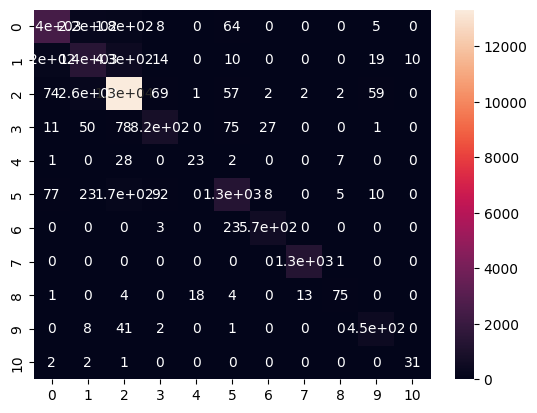

In [68]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, n_class, in_channels):
        super().__init__()

        self.conv_1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=2, padding=1)
        self.conv_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, padding=1)
